# 从0到1训练大模型
# Part 2 MateConv Mini模型构建与预训练流程

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/80.png)

- **大模型训练流程概览**

从 **0到1** 训练大模型是一个复杂而系统的工程，需要涵盖从数据准备到模型部署的多个环节。以下是一个完整的流程框架：

| 流程            | 说明                                                                                           |
|:---------------:|--|
| **数据准备**        | 收集高质量、覆盖面广的训练数据，对其进行清洗、去噪和格式化处理。划分<br>训练集、验证集，并存储为高效读取的格式。这一步为模型提供了扎实的输入基础。 |
| **硬件与环境配置**  | 为模型训练准备高性能硬件（如 A800、A100 GPU），搭建分布式训练环境，<br>并优化深度学习框架的配置。这一步确保训练效率和稳定性。 |
| **分词器训练**      | 根据训练数据量和模型任务需求，选择适合的分词算法（如 BPE 或 <br>SentencePiece）。分词器决定了模型如何理解数据，是数据与模型的桥梁。 |
| **设计模型架构**    | 选择适合的模型结构（如 GPT、BERT），并配置参数量、层数、激活函数<br>等细节。对于大规模任务，可以结合领域特点定制模型。 |
| **预训练**        | 使用无监督任务从海量数据中提取通用知识，比如语言模型的自回归建模或<br>掩码建模。预训练的效果直接影响模型后续的微调能力。 |
| **意图对齐微调**        | 通过监督微调（SFT）或强化学习对齐（RLHF），让模型学习人类偏好，<br>避免输出无意义或有害内容。对齐步骤是模型实用化的关键。 |
| **特定优化微调**  | 在特定任务（如文本分类、问答）上微调模型，结合冻结与解冻层的策略进一步<br>优化性能，满足应用需求。                          |
| **模型量化**       | 通过剪枝、量化和知识蒸馏等技术优化模型，提高推理效率，降低计算与存储<br>成本，使模型更适合部署环境。                            |
| **部署与监控**      | 将模型部署到生产环境中，使用推理优化工具提升服务效率，同时通过实时<br>监控与用户反馈不断改进模型性能和可靠性。                     |

**在课程中我们呈现的环节有——**

| 流程            | MateConv Mini<br> (0.02B) | MateConv <br> (1B) | 单独的案例 | 在这节课之前里应该掌握 |
|:---------------:|:---------------------:|:-------------:|:-:|:-:|
| **数据准备**<br>（数据收集、数据清洗、数据预处理、<br>数据分词、数据编码、掩码构建……）| ✅ | ✅ | ✅ |✅大部分已完成<br>剩下的在<font color="red">**当前课程**|
| **硬件与环境配置**<br><br> （硬件配置、环境配置、代理设置）  | ✅                     | ✅             | ✅|✅ 已完成 |
| **分词器训练**      | ✅  | --              |--|✅ 已完成|
| **设计模型架构**    | ✅  | ✅     |✅| ✅大部分已完成<br>剩下的在<font color="red">**当前课程** |
| **预训练**<br>（预训练基础理论、配置文件构建、<br>各类优化方法、分布式配置、<br>模型监控与保存配置……）          | ✅                     | ✅             |--| <font color="red">**当前课程** |
| **意图对齐微调**        | ✅                     | ✅             |--|--|
| **特定优化微调**  | --                     | --             |✅|--|
| **模型量化**       | --                   | --             |✅|--|
| **部署与监控**     | ✅                     | --             |--|--|

在进行课程讲解时，每个环节我们将采用【技术概览 - MateConv Mini代码实现 - MateConv代码实现 - 深度原理或补充】的4段式结构进行讲解、你可以挑选自己最感兴趣的部分进行学习。

## 1 MateConv Mini的模型构建

MateConv Mini是基于LlaMA3.1 + DeepSeek构建的文字生成式模型，在课程中的《LlaMA架构原理精讲与复现》板块我们已详细解读过这个架构，核心结构如下 ↓ 

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/78.png" alt="描述文字" width="600">

**MateConv Mini** 的模型架构整体设计融合了 **LLaMA-like** 和 **DeepSeek-like** 的特点，该架构从 **输入嵌入层（Embeddings）** 开始，通过多层堆叠的 Transformer 模块完成特征建模，最终通过 Softmax 输出预测结果。其中、每个 Transformer 模块由 **多查询注意力（Grouped Multi-Query Attention with KV Cache）**、**Feed Forward 模块（或 MoE）** 以及归一化和残差连接组成。

- **1. Input & Embeddings**：将离散的输入序列（如单词、字符或 Token）转换为连续向量表示，提供初始语义信息。作为整个模型的输入，提供每个 Token 的嵌入表示，用于后续的注意力和前馈处理。

- **2. RMS Norm（RMS归一化）**：对输入数据进行均方根归一化，稳定模型的训练，并加速收敛。RMS Norm 相比 Layer Norm 更高效，因为它只需计算每个样本的均方根值，而无需计算均值。

- **3. Grouped Multi-Query Attention with KV Cache**：实现自注意力机制，通过计算 Query、Key 和 Value 的相关性来捕获序列的上下文依赖。然而，我们使用的是KV共享的注意力机制、同时在推理阶段缓存 Key 和 Value，避免重复计算历史上下文，这能显著提高生成效率并且降低模型参数量。除此之外，我们还在 Query 和 Key 上引入旋转位置编码，增强模型对位置关系的建模能力，特别适用于长序列。

- **4. Feed Forward（SwiGLU）与 MoE（Experts）**：对每个 Token 的表示单独进行非线性变换，增强模型的特征提取能力。其中FFN层使用门控激活单元，通过一组门控机制控制信息流动，能够捕获更复杂的特征，而MOE层则在多个专家模块中选择性激活一个或多个（通常互斥，即“Mutually Exclusive”），使模型在不同任务上具有更高的灵活性。

- **5. Residual Connection（残差连接）**：将输入直接添加到子模块的输出上，缓解梯度消失问题、使模型能够在学习额外特征时保留输入信息，从而更有效地学习深层次的表示。

- **6. Linear & Softmax**：线性层将 Transformer 模块的输出映射到词汇表大小，用于生成词分布。Softmax 将词分布转换为概率分布，完成预测。

结合之前在讲解LlaMA时构建的代码、我们将该架构的模型脚本放在了model.py文件中 ↓

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/76.png)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/77.png)

| **代码与构建思路差异**            | **本次预训练中使用的model.py脚本**                                                                                       | **LLaMA课程中构建的LLaMA.py脚本**                                                                                          |
|--------------------------|-------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------|
|**MOE架构**|实现了MOE模型、以及共享专家机制|实现了MOE模型、以及共享专家机制|
| **KV 缓存更新**          |直接针对推理模式下 `seqlen == 1`的情况进行了优化（拼接新 Token 到缓存）、适用于自回归中只输出一个token的情况（适用于大部分情况）。                                     |通用实现、在自回归流程中无论一次输出几个token都可以实现，按照首次调用（缓存为空）和非首次调用（缓存更新）的逻辑对缓存进行选择性更新。                                       |
| **掩码处理**            |使用固定掩码矩阵 `self.mask`，假设序列长度不会变化。                                            |动态扩展掩码矩阵，适配缓存增长时的长度需求。                                                      |
| **旋转位置编码**        |在扩展 KV 之前执行旋转位置编码、高效简单避免重复计算                                                                |在扩展 KV 之后执行旋转位置编码，适配不同长度的张量输入、但计算逻辑更为复杂                                                      |
| **注意力计算**          | - 支持 Flash Attention，未支持时手动加固定掩码矩阵计算注意力。                                      |优先使用 Flash Attention，支持动态扩展掩码以适配不同序列长度。                                      |
 **动态适配性**          |假设固定掩码与序列长度，扩展性有限。                                                            |动态掩码扩展和缓存机制，适配性更强，支持任意序列增长。                                             |
| **适配性场景**          |偏向推理中已知固定长度的场景、<font color="red">**整体效率更高**。                                                                  |适配更复杂的推理场景，支持动态长度序列处理、<font color="red">**拓展性和通用性更强**。                                                      |

同时，我们为这个模型构建了如下的参数设置 ↓ 该设置在LMConfig.py脚本中 ↓

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/79.png)

```python
from transformers import PretrainedConfig


class LMConfig(PretrainedConfig):
    model_type = "MateConv Mini"

    def __init__(
            self,
            dim: int = 512,  # 模型隐藏层维度
            n_layers: int = 8,  # Transformer 堆叠的层数
            n_heads: int = 16,  # 注意力头的数量
            n_kv_heads: int = 8,  # KV（Key 和 Value）共享头的数量
            vocab_size: int = 6400,  # 词汇表的大小
            hidden_dim: int = None,  # 前馈网络中隐藏层的维度，默认为 None 时将使用 dim 的倍数
            multiple_of: int = 64,  # 前馈网络中隐藏层维度需要是该值的整数倍
            norm_eps: float = 1e-5,  # LayerNorm 或 RMSNorm 的 epsilon 参数，用于数值稳定性
            max_seq_len: int = 512,  # 最大序列长度
            dropout: float = 0.0,  # Dropout 的比例
            flash_attn: bool = True,  # 是否使用 Flash Attention（更高效的注意力实现）
            ####################################################
            # 下面是关于 MOE（Mixture of Experts，专家网络）的特定配置
            # 当 use_moe 为 False 时，以下配置无效
            ####################################################
            use_moe: bool = False,  # 是否使用专家网络（MOE）
            num_experts_per_tok=2,  # 每个 Token 被分配的专家数量
            n_routed_experts=4,  # MOE 模型中的总专家数量
            n_shared_experts: bool = True,  # 是否启用共享专家（共享权重）
            scoring_func='softmax',  # 专家选择的评分函数，默认为 'softmax'
            aux_loss_alpha=0.01,  # 辅助损失的权重系数，用于保持专家负载平衡
            seq_aux=True,  # 是否在序列级别上计算辅助损失
            norm_topk_prob=True,  # 是否对 Top-K 专家选择的概率进行归一化
            **kwargs,
    ):
        # 模型的主要参数
        self.dim = dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.multiple_of = multiple_of
        self.norm_eps = norm_eps
        self.max_seq_len = max_seq_len
        self.dropout = dropout
        self.flash_attn = flash_attn
        ####################################################
        # MOE（专家网络）的相关配置
        ####################################################
        self.use_moe = use_moe  # 是否启用专家网络
        self.num_experts_per_tok = num_experts_per_tok  # 每个 Token 被分配的专家数量
        self.n_routed_experts = n_routed_experts  # 总的专家数量
        self.n_shared_experts = n_shared_experts  # 是否共享专家
        self.scoring_func = scoring_func  # 专家选择的评分函数
        self.aux_loss_alpha = aux_loss_alpha  # 辅助损失的权重系数
        self.seq_aux = seq_aux  # 是否在序列级别上计算辅助损失
        self.norm_topk_prob = norm_topk_prob  # 是否对 Top-K 专家选择概率进行归一化
        super().__init__(**kwargs)
```

- **模型参数量的计算**

在这些参数中、以下这些参数会直接影响模型的参数规模——

| **参数名称**        | **说明**                                                                                      |
|---------------------|-----------------------------------------------------------------------------------------------|
| **`dim`**           | 模型隐藏层的维度，影响各层的权重矩阵大小。                                                     |
| **`n_layers`**      | Transformer 堆叠的层数，每层的参数规模会累加。                                                 |
| **`n_heads`**       | 注意力头的数量，影响 Query、Key、Value 以及输出的维度分配。                                     |
| **`n_kv_heads`**    | KV（Key 和 Value）的共享头数，影响 Key 和 Value 的参数规模。                                     |
| **`vocab_size`**    | 词汇表大小，影响嵌入层和输出层的参数规模。                                                     |
| **`hidden_dim`**    | 前馈网络中隐藏层的维度，直接影响前馈层的参数规模。若未设置，则为 `dim * multiple_of`。          |
| **`use_moe`**       | 是否启用专家网络（MOE）。                                                                      |
| **`n_routed_experts`** | 专家网络中路由的总专家数量，影响 MOE 模块的参数规模。                                         |

基于这些关键参数、当前架构的总参数量可以分为以下几部分计算：

**1. 嵌入层参数量**

> - **公式**：`vocab_size * dim`
>   
> - 嵌入层的参数来自词汇表大小和嵌入维度。
>
> -    $$
   \text{Embedding Params} = 6400 \cdot 512 = 3,276,800
   $$

**2. 每层自注意力机制参数量**

> - 注意力机制的参数分为 Query、Key、Value 和输出权重（`wo`），但是由于我们使用了**kv共享**机制，且借用了参数`n_kv_heads`作为共享的基础、因此注意力机制的参数量实际计算如下——
> 1. **Query 权重矩阵**：
>    - Query 是全头独立计算，因此：
>      $$
     \text{Query Params} = dim \cdot dim = 512 \cdot 512 = 262,144
     $$
> 
> 2. **Key 权重矩阵**（共享头）：
>    - Key 的参数量基于 `n_kv_heads` 和切分后的维度：
>      $$
     \text{Key Params} = n\_kv\_heads \cdot head\_dim \cdot dim = 8 \cdot 32 \cdot 512 = 131,072
     $$
> 
> 3. **Value 权重矩阵**（共享头）：
>    - Value 的参数量与 Key 相同：
>      $$
     \text{Value Params} = 131,072
     $$
> 
> 4. **Output 权重矩阵**：
>    - 输出层需要将 `n_heads` 的多头输出合并为原始维度：
>      $$
     \text{Output Params} = dim \cdot dim = 512 \cdot 512 = 262,144
     $$
> 
> **合计注意力机制参数量**：
> - Attention Params = Q Params+K Params+V Params+O Param
> $$ 262,144 + 131,072 + 131,072 + 262,144 = 786,432 $$

**3.1 每层前馈网络参数量**

> - **公式**：
>  $$
  \text{FFN Params} = 2 \cdot (dim \cdot hidden\_dim) + hidden\_dim \cdot dim
  $$
> - `2 * (dim * hidden_dim)`：前馈网络中两层全连接权重。
> - `hidden_dim * dim`：前馈层输出投影权重。
> $$ \text{FFN Params} = 3 \cdot (dim \times hidden\_dim) = 3 \cdot (512 \times 2048) = 3,145,728 $$

**3.2 如果启用MOE网络架构**

> 在MateConv mini架构中、我们MOE的结构由专家、路由、以及共享专家三部分组成——
>
>1. **专家网络的参数量（Experts Params）**：每个专家是一个 `FeedForward` 层，总共有 `n_routed_experts` 个专家。
>
> **单个专家参数量**：来自 `FeedForward` 的参数：
>     $$
     \text{Single Expert Params} = 3 \cdot (dim \cdot hidden\_dim)
     $$
> - `w1`: $ dim \rightarrow hidden\_dim $
> - `w2`: $ hidden\_dim \rightarrow dim $
> - `w3`: $ dim \rightarrow hidden\_dim $
>
>  **所有专家的参数量**：
>   $$
   \text{Experts Params} = n\_routed\_experts \cdot \text{Single Expert Params}
   $$
>
> $$
   \text{Experts Params} = n\_routed\_experts \cdot 3 \cdot (dim \cdot hidden\_dim)
   $$
>   $$
   \text{Experts Params} = 4 \cdot 3 \cdot (512 \cdot 2048)
   $$
>   $$
   \text{Experts Params} = 4 \cdot 3 \cdot 1,048,576 = 12,582,912
   $$
>
> 2. **门控网络的参数量（Gating Params）**
>   - 在 `MoEGate` 中，门控网络使用一个权重矩阵 `self.weight`：
>     $$
     \text{Gating Params} = dim \cdot n\_routed\_experts
     $$
>
>    $$
   \text{Gating Params} = dim \cdot n\_routed\_experts
   $$
>   $$
   \text{Gating Params} = 512 \cdot 4 = 2,048
   $$
> 
> 3. **共享专家的参数量（Shared Expert Params，若启用）**
>   - 如果配置了共享专家（`n_shared_experts is not None`），还需要计算共享专家的参数。
>   - 共享专家是一个额外的 `FeedForward` 层，其参数量与单个专家相同：
>     $$
     \text{Shared Expert Params} = 3 \cdot (dim \cdot hidden\_dim)
     $$
>
>   $$
   \text{Shared Expert Params} = 3 \cdot (dim \cdot hidden\_dim)
   $$
>   $$
   \text{Shared Expert Params} = 3 \cdot (512 \cdot 2048)
   $$
>   $$
   \text{Shared Expert Params} = 3 \cdot 1,048,576 = 3,145,728
   $$
> - 结合以上部分，MOE 的总参数量为：
>   $$
   \text{MoE Params} = \text{Experts Params} + \text{Gating Params} + \text{Shared Expert Params}
   $$
>   $$
   \text{MoE Params} = 12,582,912 + 2,048 + 3,145,728
   $$
>   $$
   \text{MoE Params} = 15,730,688
   $$

4. **输出层参数量**

> - **公式**：
>  $$
  \text{Output Params} = vocab\_size \cdot dim
  $$
>  在本次架构中、我们使用了**Embedding 和 Output 层共享权重**的参数优化技巧，因此 Output 层就不需要单独计算参数量，只需计算一次 Embedding 参数量即可。

5. **每层总参数量**

> 每层参数量为自注意力机制和前馈网络的参数之和：
> $$
\text{Layer Params} = \text{Attention Params} + \text{FFN Params}
$$
> $$
\text{Layer Params} = 786,432 + 2,097,152 = 2,883,584
$$

6. **所有层参数量**

> Transformer 层数为 `n_layers = 8`：
> $$
\text{Total Layer Params} = n\_layers \cdot \text{Layer Params} = 8 \cdot 2,883,584 = 23,068,672
$$

7. **总参数量**

> 总参数量包含嵌入层和所有 Transformer 层参数：
> $$
\text{Total Params} = \text{Embedding Params} + \text{Total Layer Params}
$$
> $$
\text{Total Params} = 3,276,800 + 23,068,672 = 26,345,472
$$
> 即26.3MB（两千六百万参数）、即0.02B模型。

8. **如果启用MOE层**

> 如果启用MOE层、那每层参数量为自注意力机制和MOE参数之和：
> $$
\text{Layer Params} = \text{Attention Params} + \text{MOE Params}
$$
> $$
\text{Layer Params} = 786,432 + 15,730,688 = 16,517,120
$$
> 在总层数`n_layers = 8`的情况下，所有层总参数量为：
> $$\text{Total Layer Params} = n\_layers \cdot \text{Layer Params} = 8 \cdot 16,517,120 = 132,136,960
$$
> 整体架构的总参数量包含嵌入层和所有 Transformer 层参数：
> $$
\text{Total Params} = \text{Embedding Params} + \text{Total Layer Params}
$$
> $$
\text{Total Params} = 3,276,800 + 132,136,960 = 135,413,760
$$
> 即135.4MB（一亿三千五百万参数）、即0.1B模型。

<center><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/78.png" alt="描述文字" width="600">

## 2 MateConv Mini的预训练代码全解

正如之前所说，这样的架构所需的算力是——

| 模型名称     | 模型参数量级      | 数据量级                | 硬件资源               | 训练时间              | 训练成本                |
| ------------ | ----------------- | ----------------------- | ---------------------- | --------------------- | ----------------------- |
| **MateConv mini** | 0.02B<br>（两千万参数） | 约60G（分词器约1G、预训练约35G、微调约20G） | RTX 3090 x2           | 全流程约3-4天          | AutoDL租赁，约250元     |
| **MateConv**      | 1B<br>（10亿参数）      | 约3~4T文本+1T代码（实际收集超过10T数据、如果你们有更大的运存可以使用更大的数据集） | A800 x 8，硬盘4T      | 全流程约1个多月（预训练约20天） | AutoDL租赁2.5\~3万元；购置设备需80\~100万元，电费约3000r |

预训练脚本 ↓

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/83.png)

运行全流程的代码 ↓

```shell
cd ~/autodl-tmp/MateConv

touch pretrain.py

deepspeed --master_port 29500 --num_gpus=4 pretrain.py --epochs 30
```

开始训练 ↓

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/0d46acea891701fd573115782288e05.jpg" alt="0d46acea891701fd573115782288e05" style="zoom:50%;" />

训练结束 ↓ 训练流程大约18个小时。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/9f1b2321dc79550b1e0f194e165ff22.png" alt="9f1b2321dc79550b1e0f194e165ff22" style="zoom:50%;" />

### 2.1 训练流程与训练脚本构建

#### 2.1.1 深度学习训练的基本流程

深度学习模型的训练流程本质上是一个优化的流程，其**目标是通过不断迭代模型参数$w$，使模型在给定数据上的预测尽可能接近真实值**，简单来说，模型是“从错误中学习、通过损失函数的指导、不断调整自身的参数让预测更加准确”。为了实现这个目标、我们通常需要掌握优化算法、迭代流程等具体技术细节（<font color="red">**详细内容可参考《深度学习实战》课程**</font>）、但优化算法的内容本身繁多且难度较高、在这里我们跳开原始理论、以最快的速度、比较通俗的方式向大家展现深度学习的基本训练流程、为后续理解预训练的流程做好准备。

---

<font color="red">**在定义好模型之后、深度学习训练的基本步骤与流程如下**——

1. **数据分批/打乱/分训练集验证集等操作、定义使用的CPU/GPU等细节**

2. **初始化模型参数（Parameter Initialization）**

3. **训练循环（training loop）**：
> **正向传播（Forward Pass）**：输入数据通过模型，得到预测输出。
> 
> **计算损失（Compute Loss）**：根据模型的预测结果和真实标签，计算损失函数值。
> 
> **反向传播（Backward Pass）**：根据损失函数的值，计算模型中各参数的梯度（使用自动微分）。
> 
> **参数更新（Update Parameters）**：根据计算出的梯度，使用优化器更新模型的参数。
> 
> **梯度清零（Zero Gradients）**：为了避免梯度累积，需要在每次迭代前将梯度归零。

4. **训练监控与模型保存**

---

在实际训练时、我们可以自定义进行多少次循环、进行怎样的循环。同时，在深度学习训练过程中、你还需要掌握如下的概念——

- **Epoch**：是**整个训练数据集被完整地传递一次通过模型**的过程，模型见过一次完整的数据、叫做执行了一个epoch。
  
- **Batch 与 Batch Size**：在深度学习中，由于计算资源的限制，训练时不会一次性将整个数据集输入模型，而是将数据分成多个小组，每个小组称为一个 Batch。模型会逐个处理这些 Batch，并在每个 Batch 上完成一次正向传播和反向传播。Batch Size 是指 每个 Batch 中包含的样本数量。
  
- **梯度（Gradients）**：是优化过程中计算出的方向信息，用于指导权重更新。从数学上来说，梯度是**损失函数相对于模型参数的导数构成的向量**，梯度决定了参数更新的方向、指向损失函数下降最快的方向、而梯度值的大小影响参数更新的幅度。

- **优化算法（Optimizer）**：使用梯度来对参数进行迭代的实际算法、不同的优化算法有不同的迭代细节、但本质都是计算损失、反向传播求解梯度、进行参数更新的方式来迭代参数。常见的有Adam、SGD、RMSProp等等。

- **学习率（Learning rate）**：是控制**每次权重更新步幅大小**的超参数，通常记为$\eta$。学习率控制了优化步幅，影响训练稳定性和速度。

- **提前停止（Early_stopping）**：在训练过程中监控模型在验证集上的性能，当性能不再提升时，提前结束训练，以避免模型在训练集上过度拟合。

下面是执行深度学习训练时、最简单的一套伪代码——

```python
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# 假设我们有以下准备好的模块
# - 自定义的模型：MyModel
# - 数据集：MyDataset
# - 损失函数：loss_fn
# - 优化器：optimizer

# 定义超参数
num_epochs = 10        # 训练的轮数
batch_size = 32        # 批次大小
learning_rate = 0.001  # 学习率

# 数据准备
train_dataset = MyDataset(train=True)  # 定义训练数据集
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 数据加载器

# 模型初始化
model = MyModel()  # 初始化模型
model = model.to("cuda" if torch.cuda.is_available() else "cpu")  # 将模型移至 GPU 或 CPU

# 损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 假设是分类任务
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练循环
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()  # 进入训练模式

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # 将数据移动到设备
        inputs, targets = inputs.to("cuda"), targets.to("cuda")

        # 1. 正向传播
        outputs = model(inputs)

        # 2. 计算损失
        loss = loss_fn(outputs, targets)

        # 3. 梯度清零
        optimizer.zero_grad()

        # 4. 反向传播
        loss.backward()

        # 5. 更新参数
        optimizer.step()

        # 打印训练状态
        if batch_idx % 10 == 0:  # 每 10 个批次打印一次
            print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

    # (可选) 每个 epoch 完成后，验证模型性能
    print(f"Epoch {epoch + 1} Completed!")

# (可选) 保存模型
torch.save(model.state_dict(), "model.pth")
print("Training Completed!")

现在你知道了，深度学习的训练流程通常包括从数据加载开始，将输入数据经过模型的正向传播得到预测结果，然后通过损失函数计算预测值与真实值之间的差异，再通过反向传播算法计算模型参数的梯度，利用优化器更新模型参数，最后清零梯度以准备下一轮迭代。

**然而，在大模型训练中，这一流程被扩展为更复杂的分布式场景，涉及跨多机多卡的高效数据并行和模型并行**，使用更大的批次来稳定训练，同时引入梯度检查点、混合精度训练等优化技术以减少内存占用和计算开销。此外，大模型的训练还会包括预训练和微调两个阶段，分别用于学习通用特征和适应特定任务。通过这种分布式、高效的训练流程，大模型能够在大规模数据和复杂任务中表现出色。

#### 2.1.2 从训练流程到完整预训练脚本

现在我们已经了解了深度学习模型训练的核心流程，然而**在核心训练流程之外、我们还要设置大量机制来辅助训练流程**，包括但不限于——

**数据加载**：在训练深度学习模型之前，需要高效地加载和预处理数据。这包括数据的读取、预处理（如归一化、数据增强）、批量生成以及多线程数据加载优化等，以提高训练效率。在本次MateConv mini预训练流程中，我们定义了Dataset.py作为最终的数据处理脚本，并且我们会在最终的训练脚本中引用到它。

**模型断点续训机制**：断点续训机制的意义在于保证深度学习模型在长时间训练过程中，即使因系统崩溃、设备重启或意外中断，也能从最近一次保存的状态继续训练，而无需从头开始。对于计算资源昂贵的深度学习任务，特别是大规模语言模型（LLM）或计算密集型任务，如计算机视觉和强化学习，断点续训可以有效减少训练时间和成本，提高训练的可靠性。

**分布式训练设置与分布式相关的命令行参数设置**：分布式训练可以加速大规模模型的训练过程，通常采用数据并行或模型并行的方法。主流框架如 PyTorch 和 TensorFlow 提供了分布式训练支持，同时deepspeed和megatron等框架也支持更大规模、更灵活的分布式预训练构建、这样可以提高计算资源利用率、加速模型的训练。  

**动态学习率调整**：学习率是深度学习训练中最核心的参数没有之一。动态调整学习率（如学习率衰减、Warmup、Cosine Annealing）在于可以提高神经网络训练的稳定性和收敛效率，使模型能够更快达到最优解，同时避免训练过程中的震荡或过早陷入局部最优。固定学习率在训练的不同阶段可能无法适应梯度变化，初始学习率过大会导致训练不稳定，甚至梯度爆炸，而过小的学习率可能导致收敛速度缓慢甚至陷入平稳区间。通过采用动态调整策略，例如学习率衰减（如 Step Decay、Exponential Decay）、Warmup 预热、Cosine Annealing 或自适应优化算法（如 Adam、SGD with momentum），可以在训练初期使用较大学习率加快收敛，在训练后期逐步减小学习率，以精细调整权重，从而提高泛化能力，减少损失震荡，并提升最终模型的性能和稳定性。

**梯度优化机制**：神经网络训练讲解“稳”字决、在训练流程中我们会有许多技巧用于提升模型的稳定性（即模型的梯度稳定性）。梯度优化机制在深度学习训练中至关重要，它们旨在提高训练的稳定性、优化显存使用，并防止梯度异常波动对模型收敛造成影响。例如，梯度累积（Gradient Accumulation）是一种在显存受限的情况下模拟大 batch 训练的方法，通过在多个小批次中累积梯度后再更新参数，使得训练更加稳定，并提升模型的收敛质量。梯度裁剪（Gradient Clipping）则用于防止梯度爆炸，特别是在深度网络或长序列建模中，通过限制梯度的最大范数或值，避免因梯度过大导致的训练不稳定。此外，自适应梯度调整方法（如 Adam、RMSprop）可以根据参数的历史更新情况动态调整学习率，从而优化收敛速度，而梯度正则化（如 L2 正则化）能够防止过拟合，使模型在复杂任务中具备更强的泛化能力。这些梯度优化策略相互配合，使得深度学习训练更加高效、稳定，并提高最终模型的性能。

**显存优化/训练加速策略**：在深度学习训练中，显存（VRAM）往往是一个瓶颈，尤其是在大规模模型（如 LLM）和高分辨率计算机视觉任务中，标准的 FP32 计算会占用大量显存。而 FP16 数据格式的数值表示范围更小，占用的显存空间仅为 FP32 的一半，因此可以在相同的 GPU 资源下处理更大的 batch size，提高训练吞吐量、从而提升整体的训练效率。在大模型训练阶段、我们常常使用混合精度训练机制（Mixed Precision Training），利用 FP16（半精度浮点数）与 FP32（单精度浮点数）混合计算，以减少显存占用并加速计算，同时借助自动损失缩放（Loss Scaling）避免数值不稳定问题。

**日志记录**：训练过程中需要记录关键指标（如损失值、精度、学习率等），可以使用 TensorBoard、WandB 或日志文件，以便后续分析模型的训练过程和性能优化。  

**模型保存**：训练完成后，需要保存模型的权重、优化器状态等，以便后续推理或继续训练。通常采用 `.pth`（PyTorch）或 `.h5`（TensorFlow/Keras）格式存储，并可以结合检查点（checkpoint）机制定期保存模型状态。

然而，在我们将这些功能组成脚本的时候，我们需要的是**模块化编程**的基本思路。整个训练脚本通常由多个独立的功能模块组成，例如数据加载、分布式训练、动态学习率调整、混合精度计算、梯度优化等，每个模块负责特定的功能，并被设计成独立的函数或类，以便单独调试和复用。在主程序中，这些模块被依次初始化并串联起来，形成完整的训练流程。**因此，整个脚本可以分为两大部分**——

1. **定义各个功能模块（函数）**<br><br>
   - 这些函数是 **独立的、可复用的功能单元**，包括：<br><br>
     - `Logger()` → 负责日志记录
     - `get_lr()` → 计算动态学习率
     - `train_epoch()` → 训练单个 epoch
     - `init_model()` → 初始化模型（支持断点续训）
     - `init_distributed_mode()` → 初始化 DDP 分布式训练
     - 单独的Dataset.py和model.py用于支持模型和数据的处理
      

 
2. **主程序（`if __name__ == "__main__":`）**<br><br>
   - 负责 **解析参数、加载数据、初始化模型、配置训练环境**。
   - 依次 **调用前面定义的函数**，组织整个训练流程。

这相当于先建积木（功能模块），然后搭建房子（主程序），既清晰又高效，符合工程化深度学习训练的最佳实践。

### 2.2 分布式预训练的基础概念与代码配置

分布式（Distributed）是一种计算方式，指将计算任务分布到多个节点上进行协同处理，以提升计算效率或处理更大规模的任务。在深度学习中，**分布式训练的目标是利用多个设备（如 GPU 或 CPU）来加速模型的训练或支持训练更大的模型**。

在分布式中，你常常会听到这些基础概念——

- **进程（Process）**：**一个独立的程序运行实例、比如训练一个神经网络**。该实例本身拥有自己的内存空间、文件描述符等资源。**在分布式训练中，每个 GPU 通常只会被分配一个进程，每个进程独立处理模型计算任务**。进程之间相互独立，彼此的内存空间不能直接访问，需要通过进程间通信（如共享内存、消息队列）进行数据交换。

-  **节点（Node）**：在多机训练中，每台机器是一个节点、每个节点可能有多个 GPU，多个节点通过高速网络（如 InfiniBand）进行通信，完成分布式训练。每个 GPU 可以运行一个或多个进程（通常是一个）。

- **线程（Thread）**：线程是进程的执行单元，**通常对应程序的一条指令流（比如执行一段代码）**，一个进程可以包含多个线程，线程共享进程的内存和资源。线程共享进程的资源，而进程之间是独立的、线程创建和切换的开销比进程小。在深度学习中、多线程机制常常用于数据预处理、数据加载、并行模型计算等等。<font color="red">**大部分时候、想要实现多线程操作、我们只需调整线程相关的超参数即可、但是想要多进程操作、则必须使用PyTorch DDP以及DeepSpeed这样的分布式框架来进行辅助**。

-  **单机多卡（Single Node Multi-GPU）**：单机多卡是指在一台物理机器上使用多个 GPU 进行并行训练、也就是只有1个节点、但是可以有多个进程。在一台机器上、多个GPU之间通过共享内存或高速总线（如 PCIe）进行通信、含有PCIe功能的显卡价格会更昂贵。这种方式的 GPU 间通信延迟较低，数据传输通过共享内存完成。使用 `torch.nn.DataParallel` 或 `torch.nn.parallel.DistributedDataParallel` 可以方便实现单机多卡训练。

- **多机多卡（Multi-Node Multi-GPU）**：多机多卡是指使用多台物理机器，每台机器上有多个 GPU，通过高速网络将这些机器连接起来，共同进行分布式训练。节点之间的通信需要通过网络（如 Ethernet 或 InfiniBand），通信延迟比单机多卡高，还需要使用 NCCL、GLOO 或 MPI 等通信协议来通信后端。在需要利用数百甚至数千个 GPU 时，通常采用多机多卡训练方式。例如 GPT-3、BERT 等大规模模型的预训练。

不难发现，只有跨进程、跨设备的训练才需要用到多个设备，因此分布式训练是指跨进程的训练、多线程并行不是分布式运算的一部分。

在分布式训练中、我们有两种主要训练方式——

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/82.png)

#### 2.2.1 数据并行（Data Parallelism）
  
数据并行是将训练数据划分为多个不重叠的部分，并分配给不同的设备（如 GPU），每个设备上独立计算正向传播和反向传播，然后同步梯度更新参数。在数据并行中、**模型副本在每个设备上完全相同、而训练数据被分片**，每个设备只处理其中一部分、计算负载与设备数成正比。

在数据并行时，每个设备独立运行正向传播和反向传播、设备间同步梯度，更新模型参数。这种方式简单高效，适用于大多数场景、但是有设备之间存在通信开销。

- **为什么一定要通信？不通信不行吗？**

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/81.png)

上述图像展示了pytorch中的`DistributedDataParallel`类的具体流程——

1. **Dataloader（左侧）**：
   - 数据加载器（Dataloader）负责将训练数据划分为批次（Batch），然后分发给各个 GPU。
   - 每个 GPU 处理的数据来自一个分片，确保数据互不重叠。
<br><br>
2. **模型副本（紫色 LLM）**：
   - 每个 GPU 上都有一份相同的模型副本。
   - 所有设备共享同一组初始参数，但独立运行正向传播和反向传播。
<br><br>
3. **Forward/Backward Pass（正向和反向传播）**：
   - 每个 GPU 对其分配的数据进行正向传播（计算输出）和反向传播（计算梯度）。
   - 这些计算完全独立，因此可以并行进行。
<br><br>
4. **梯度同步（Synchronize Gradients）**：
   - 在反向传播完成后，各个 GPU 之间会通过通信操作（如 `all_reduce`）同步它们计算出的梯度。
   - 同步后的梯度是所有 GPU 的平均值，用于确保模型参数的一致性。
<br><br>
5. **模型更新（Update Model）**：
   - 每个 GPU 使用同步后的梯度更新自己的模型副本。
   - 更新后的模型在下一轮迭代时仍保持一致。

#### 2.2.2 模型并行（Model Parallelism）

模型并行是将模型的不同部分分配到不同的设备上，多个设备合作完成正向传播和反向传播。在模型并行中、数据在多个设备间共享、每个设备负责模型的一个子部分。常用于超大模型（如 GPT-3、PaLM 等）的训练。

在模型并行时、**数据还是会被分片、每次处理的数据是全局数据的一个子集**。同时，**分割在不同设备上的模型结构大多可以并行**，这样在一群可并行的设备处理完数据自己后、就会将信息传递给下一群可并行的设备。反向传播时，设备按相反顺序逐步计算梯度。这种方式能够训练内存需求极大的模型。但是实现起来极其复杂（因为需要对模型进行拆分），设备间通信更多。

在模型并行中，模型的不同部分（如网络层或参数分块）被分配到不同的设备，每个设备只负责处理一部分模型权重。因此，**模型的前向传播和反向传播需要跨设备传递中间计算结果和梯度**，前向传播时，每个设备必须将模型中间激活值（activation）传递给下一个设备。激活值的大小通常很大（取决于 Batch Size 和神经元数），传输这些值需要大量通信。反向传播时，设备需要将梯度值传递给计算前一层的设备。
每层梯度的大小与模型的权重规模相同，因此反向传播也会产生大量通信。为了解决这个问题，我们现在有管道并行（pipeline parallelism）、ZeRO优化、以及混合并行（Hybrid Parallelism）等更前沿的手段、不过这些手段在0.02B模型的训练流程中并不常见。

- **模型具体如何并行？**

**1.层级并行（Layer-wise Parallelism）**：

将模型的不同层分配到不同设备。例如，Transformer 的第 1-6 层分配到 GPU 0，第 7-12 层分配到 GPU 1。前向传播时，输入通过第 1-6 层后，将结果传递给第 7-12 层。反向传播时，梯度以相反顺序传递。

**例如**：
```python
import torch
import torch.nn as nn

class TransformerLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attention = nn.Linear(dim, dim)  # 简化的注意力层
        self.feedforward = nn.Linear(dim, dim)  # 简化的前馈层

    def forward(self, x):
        x = self.attention(x)
        x = self.feedforward(x)
        return x

# 分配层到不同设备
device_0 = torch.device("cuda:0")
device_1 = torch.device("cuda:1")

layers = [TransformerLayer(512).to(device_0) for _ in range(6)] + \
         [TransformerLayer(512).to(device_1) for _ in range(6)]

def forward(x):
    for i, layer in enumerate(layers):
        x = x.to(layer.attention.weight.device)  # 确保输入数据在对应设备上
        x = layer(x)
    return x

这种方式实现简单。适合模型深度较大、层数较多的情况。层之间依赖较强，设备间通信多。可能导致部分设备计算空闲（负载不均）。

**2. 算子并行（Operator Parallelism）**

将同一层中的算子（例如矩阵乘法、激活函数等）分配到不同设备。例如，Transformer 的注意力机制可以在多张 GPU 间分块计算。适合单层计算量巨大的情况、可均衡不同设备的负载。但是问题在于、通信开销大，因为算子之间的结果需要频繁交换、需要精细的实现和调度。

**3. 张量切分（Tensor Parallelism）**

将模型参数的张量切分到不同设备。例如，将 Transformer 中的注意力权重或前馈层的权重分为多个块，每个块分配给不同 GPU。前向传播时，各设备独立计算自己负责的部分，然后汇总。反向传播时，各设备计算梯度并同步。这种方式适合参数规模较大的情况、可避免单个设备内存不足的问题，但是实现非常复杂、需要频繁同步各种张量。

**例如**：

- 将每个 Transformer 层的权重矩阵沿某一维度切分到不同设备。例如，注意力权重分为两部分：
  - GPU 0：负责权重的左半部分。
  - GPU 1：负责权重的右半部分。
- 前向传播：
  - 每个设备独立计算其分配的部分，结果汇总后返回。
- 反向传播：
  - 梯度按张量分片同步。

```python
import torch

class ParallelAttention(nn.Module):
    def __init__(self, dim, device):
        super().__init__()
        self.q = nn.Linear(dim // 2, dim // 2).to(device)
        self.k = nn.Linear(dim // 2, dim // 2).to(device)

    def forward(self, x):
        q = self.q(x[:, :x.shape[1] // 2])  # 分片输入
        k = self.k(x[:, x.shape[1] // 2:])
        return q @ k.T

# GPU 分片
device_0 = torch.device("cuda:0")
device_1 = torch.device("cuda:1")

parallel_attention = ParallelAttention(512, device_0)
x = torch.randn(64, 512).to(device_0)
output = parallel_attention(x)
```

**4. 流水线并行（Pipeline Parallelism）**

将模型按层分配到不同设备，同时分割数据为多个小批次（Micro-Batches），以流水线方式并行处理。例如，GPU 0 处理第 1-6 层的第 1 小批次数据时，GPU 1 可以同时处理第 7-12 层的前一个小批次数据。这样提高设备利用率，但是同样实现非常复杂、通信开销高。

- 将 Transformer 的层按顺序划分到不同设备，并以小批次为单位进行流水线处理。
  - GPU 0：处理第 1-6 层。
  - GPU 1：处理第 7-12 层。
- 流水线机制：
  - 小批次 1：通过 GPU 0 后传递给 GPU 1。
  - 小批次 2：在 GPU 0 计算时，GPU 1 同时处理前一个小批次。

**例如**：
```python
# 使用 PyTorch 的 PipelineParallel 实现
from torch.distributed.pipeline.sync import Pipe
from torch.nn import Sequential

device_0 = torch.device("cuda:0")
device_1 = torch.device("cuda:1")

model = Sequential(
    *[TransformerLayer(512).to(device_0) for _ in range(6)],
    *[TransformerLayer(512).to(device_1) for _ in range(6)]
)
model = Pipe(model, chunks=2)  # 设置流水线并行的分块数
```

#### 2.2.3 `torch.distributed`与`DDP`的数据并行实现

- **数据并行 vs. 模型并行**
 

 
| **对比项**         | **数据并行（Data Parallel, DDP）** | **模型并行（Model Parallel, MP）** |
|--------------------|---------------------------------|---------------------------------|
| **核心思想**       | 每个 GPU 训练一份完整的模型，但处理不同的数据 | 把模型拆分到多个 GPU，每个 GPU 只训练一部分 |
| **适用场景**       | 适用于模型规模适中，单个 GPU 能存下整个模型 | 适用于超大模型，单 GPU 放不下整个模型 |
| **梯度同步**       | 需要在所有 GPU 之间同步梯度 | 不需要同步整个模型梯度，但需要 GPU 之间传递计算结果 |
| **适用任务**       | ImageNet 训练、GPT/BERT 训练、目标检测 | GPT-3 训练、T5-XXL、DeepLabV3+、长序列 Transformer |
| **计算通信开销**   | 通信开销较小，适合高效扩展 | 通信开销大，训练更复杂 |
| **扩展方式**       | 可以简单扩展到 **多机多卡（数百 GPU）** | 适用于 **单机多卡或有限多机多卡** |

- **什么时候用数据并行？什么时候用模型并行？**

| **情况** | **使用数据并行（DDP）？** | **使用模型并行（MP）？** |
|----------|-----------------|----------------|
| **模型参数少于 10 亿** | ✅ DDP 更适合 | --模型并行 |
| **单 GPU 无法存下模型** | ❌ 不适合 | ✅ 需要模型并行 |
| **需要处理大数据** | ✅ DDP 并行加速 | ❌ 模型并行不会加速数据计算 |
| **训练 GPT-3、PaLM 这样的大模型** | ❌ 不适合 | ✅ 需要模型并行 |

因此在本次的MateConv mini训练过程中、面对小型的、能够一整个放置到单卡上的模型，**我们选择的是数据并行的实现方式**，并且我们是依赖于和`torch.distributed`这个分布式通信库和`torch.nn.parallel.DistributedDataParallel`这个数据并行实现类来实现分布式训练本身。

- **torch.distributed**

`torch.distributed` 是 **PyTorch 的底层分布式通信库**，它为分布式预训练提供**跨设备通信支持、跨设备参数管理、进程管理**等功能，它能够支持不同的通信后端（如 `NCCL`、`Gloo`、`MPI`）、也能支持跨设备管理分布式进程的同步、反向传播等流程、并且它有强大的兼容性、能够与各类分布式框架如deepspeed、MagatronLM等联合运行。在现代分布式训练流程中、无论是执行单机多卡续联、多机多卡训练、无论是执行数据并行、还是模型并行、`torch.distributed`都是我们必须依赖的根基库。

在 PyTorch 中，我们通常 **`import torch.distributed as dist`**，然后使用它来管理分布式训练进程。下面是一些最常见的操作：

| **操作** | **作用** |
|---------|--------|
| `dist.init_process_group()` | 初始化分布式训练环境 |
| `dist.get_rank()` | 获取当前 GPU 进程的编号 |
| `dist.get_world_size()` | 获取所有 GPU 进程的总数 |
| `dist.barrier()` | **同步所有 GPU 进程** |
| `dist.all_reduce(tensor, op=dist.ReduceOp.SUM)` | **让所有 GPU 计算出的 `tensor` 求和** |
| `dist.broadcast(tensor, src=0)` | **让 `rank=0` 的 GPU 把 `tensor` 发送给所有 GPU** |
| `dist.scatter(tensor, scatter_list, src=0)` | **让 `rank=0` 把不同的数据块分配给不同的 GPU** |
| `dist.gather(tensor, gather_list, dst=0)` | **让所有 GPU 进程的 `tensor` 汇总到 `rank=0`** |
| `dist.destroy_process_group()` | **关闭分布式训练进程** |

**其中我们需要关注的有——**


<font color="green">**1. 初始化分布式进程与分布式参数**</font>：每个 DDP 进程（每个 GPU）在启动时都需要进行初始化，以加入分布式训练进程组。
  
```python
import torch.distributed as dist

dist.init_process_group(backend="nccl")  # 或者 backend="gloo"（CPU）或 "mpi"
```
- `backend="nccl"`：适用于 **NVIDIA GPU**，性能最好（推荐）。
- `backend="gloo"`：适用于 **CPU 和 GPU**，在 CPU-only 任务中使用。
- `backend="mpi"`：适用于 **MPI 通信协议**（较少用）。

大部分时候，我们还需要手动额外传递 `world_size` 和 `rank` 参数，尤其是在多机多卡状态下、更需要明确具体的进程数。

```python
dist.init_process_group(backend="nccl", world_size=4, rank=0)
```
- `world_size`：所有进程的总数（如 4 台机器，每台 2 张 GPU，则 `world_size=8`）。注意，对于分布式训练框架（如deepspeed）而言，进程总数就等同于GPU总数量、因为各类分布式训练框架总是在每个GPU上只设置一个进程的。
- `rank`：当前进程的编号（0 表示主进程，其他进程按顺序编号）。

然而大部分时候，我们会在命令行中直接设置world_size，例如 ↓

```shell
deepspeed --master_port 29500 --num_gpus=4 --num_nodes=2 pretrain.py

#或者

torchrun --nnodes=2 --nproc_per_node=4 pretrain.py

```

这段命令行中的`num_gpus`/`nproc_per_node`参数乘以`num_nodes`就等同于world_size，**当我们在命令行中指定了这个参数后、就等同于设置了环境变量["WORLD_SIZE"]**，并且执行了下面的python代码 ↓

```python

import os
import torch.distributed as dist

# 设置分布式环境变量
os.environ["MASTER_ADDR"] = "127.0.0.1"  # 主节点 IP 地址
os.environ["MASTER_PORT"] = "29500"      # 主节点通信端口
os.environ["WORLD_SIZE"] = "4"           # 总进程数
os.environ["RANK"] = "0"                 # 当前进程编号（手动设置为 0，用于测试）
os.environ["LOCAL_RANK"] = "0"           # 本地 GPU 编号（自动设置为 0）

# 从环境变量中读取
world_size = int(os.environ["WORLD_SIZE"])  # 总进程数
rank = int(os.environ["RANK"])  # 当前进程编号
local_rank = int(os.environ["LOCAL_RANK"])  # 当前 GPU 编号

# 初始化分布式进程
dist.init_process_group(backend="nccl", world_size=world_size, rank=rank)
torch.cuda.set_device(local_rank)  # 绑定 GPU


```

如你所见，deepseek会帮助我们自动计算 world_size（即 num_gpus 传递的值）、自动分配 rank（进程 ID）、自动绑定 local_rank 到每个 GPU、还会完成自动初始化 DistributedDataParallel (DDP)。同时，在分布式训练中，每个进程会在自己的上下文中独立执行预训练脚本，但环境变量的设置确保每个进程能够识别自己的身份（RANK）和所绑定的设备（LOCAL_RANK），因此不同GPU上的rank编号以及local_rank编号是不同的。

---

<font color="green">**2. 进程间通信**</font>
`torch.distributed` 提供了一系列 **分布式通信 API**，用于 GPU 进程之间的数据交换。

-  **`dist.all_reduce()`**
**所有 GPU 进程计算出的数据进行 `reduce` 操作（如求和、平均值等）**
```python
tensor = torch.tensor([1.0]).cuda()
dist.all_reduce(tensor, op=dist.ReduceOp.SUM)
print(f"Rank {dist.get_rank()} has tensor: {tensor.item()}")
```
例如，上述代码就等同于让**所有 GPU 进程的 `tensor` 进行求和**，然后同步到每个进程。`op=dist.ReduceOp.SUM`表示 **所有 GPU 计算出的值相加**（可以改成 `MAX`、`MIN` 等）。

=========

-  **`dist.broadcast()`**
**让某个进程（如 rank=0）把数据广播给所有进程**
```python
tensor = torch.zeros(1).cuda()
if dist.get_rank() == 0:
    tensor.fill_(10)  # 只有 rank 0 设置值
dist.broadcast(tensor, src=0)  # 让 rank 0 广播给所有 GPU
print(f"Rank {dist.get_rank()} has tensor: {tensor.item()}")
```

让 `rank=0` 的 GPU 把 `tensor` 发送给所有 GPU。

=========

-  **`dist.scatter()`**
**让 `rank=0` 把不同的数据块分配给不同的 GPU**
```python
if dist.get_rank() == 0:
    tensor_list = [torch.tensor([i]).cuda() for i in range(dist.get_world_size())]
else:
    tensor_list = None
tensor = torch.zeros(1).cuda()
dist.scatter(tensor, scatter_list=tensor_list, src=0)
print(f"Rank {dist.get_rank()} received {tensor.item()}")
```
让 `rank=0` 把 `tensor_list[i]` 发送给 `rank=i`。

=========

-  **`dist.gather()`**
**让所有 GPU 进程把数据汇总到 `rank=0`**
```python
tensor = torch.tensor([dist.get_rank()]).cuda()
gather_list = [torch.zeros(1).cuda() for _ in range(dist.get_world_size())] if dist.get_rank() == 0 else None
dist.gather(tensor, gather_list=gather_list, dst=0)
if dist.get_rank() == 0:
    print(f"Gathered list: {[t.item() for t in gather_list]}")
```
所有 GPU 进程的 `tensor` 会被收集到 `rank=0`。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/81.png)

想想在数据并行过程中、可能会遇到哪些流程？首先要对数据进行分配、在经过每个线程上不同的模型处理后、还需要同步梯度（`dist.all_reduce()`功能）、在多机训练中，还需要保证各个设备上除了模型权重之外的超参数也一致（如学习率调整，可能就需要使用`dist.broadcast()`功能）。

---

<font color="green">**3. 获取进程信息**</font>
在多 GPU 训练中，我们可能需要知道当前进程的 `rank` 和 `world_size`：

```python
rank = dist.get_rank()  # 获取当前进程的 rank
world_size = dist.get_world_size()  # 获取总进程数
print(f"进程 {rank} / {world_size} 正在运行...")
```

- **`dist.get_rank()`**：返回当前 GPU 进程的编号。
- **`dist.get_world_size()`**：返回当前分布式环境中的总 GPU 数量。

---

<font color="green">**4. 同步所有 GPU**</font>
在某些情况下，我们需要**确保所有 GPU 进程都完成某个步骤后再继续执行**，这时候可以使用 `dist.barrier()`：
```python
dist.barrier()  # 阻塞所有 GPU 进程，直到所有进程都到达这里
```
确保所有进程同步，防止某些 GPU 过快进入下一步。

---

<font color="green">**5. 关闭分布式进程**</font>
当所有进程训练完毕时，需要手动关闭分布式进程：
```python
dist.destroy_process_group()
```

---

如你所见，`torch.disbributed`支持了丰富的底层自定义功能、用以支持丰富的数据流实现，然而这个过程如果全都要手动实现的话就过于复杂了。而`torch.nn.parallel.DistributedDataParallel(DDP)`类在此时出现、它为我们实现了基于torch.distributed的完整数据并行流程。<font color ="red">**DDP为我们封装并简化了整个数据并行流程、它使用 torch.distributed 的 API（如 dist.all_reduce 和 dist.broadcast）在内部完成梯度同步和权重更新，因此我们只需要调用`torch.nn.parallel.DistributedDataParallel`就可以简单运行多线程的分布式数据并行、而无需再认为进行任何的干涉**。

- **`torch.nn.parallel.DistributedDataParallel (DDP)`**

`torch.nn.parallel.DistributedDataParallel (DDP)` 是 PyTorch 提供的高性能分布式数据并行训练工具，用于在多 GPU 或多机多卡场景下高效地训练深度学习模型。DDP 的核心功能是通过**为每个 GPU 启动一个独立进程**，实现**模型副本的并行计算**，并在反向传播时**自动同步所有进程的梯度**。它能充分利用分布式硬件资源，避免传统 `DataParallel` 中的通信瓶颈，是当前大规模分布式训练的主流方法。

**重要参数**

1. **`module`**：传入需要并行训练的模型（通常是 `torch.nn.Module` 对象）。DDP 会为模型创建每个 GPU 的副本，并在各进程上运行。

2. **`device_ids`**：指定当前进程使用的 GPU。如果在单机多卡训练中，可以传入 `[local_rank]`，如：
     ```python
     model = DistributedDataParallel(model, device_ids=[local_rank])
     ```
在多机训练时，通常由 `local_rank` 环境变量动态决定。

3. **`output_device`**（可选）：指定输出数据或者模型的设备，通常与 `device_ids` 相同。默认值为 `device_ids[0]`。

4. **`find_unused_parameters`**：是否在每次反向传播中查找未使用的参数。默认值为 `False`，建议只在模型中存在条件分支（如动态网络结构）时设置为 `True`，否则会增加开销。

5. **`gradient_as_bucket_view`**：是否在梯度同步时使用内存高效的 `bucket view`。默认值为 `False`，在高效内存管理场景中建议设为 `True`。在`torch.nn.parallel.DistributedDataParallel (DDP)`中，所有模型参数的梯度在计算完成后需要同步到所有设备。这些梯度通常会分块（分组）进行同步，每一组梯度被称为一个 bucket。在使用`bucket view`机制时，DDP 会将模型参数按照大小排序，然后将它们分成多个 bucket、让每个 bucket 包含多个参数的梯度，然后在梯度同步时，DDP 会逐个 bucket 同步，而不是逐个参数同步，从而降低通信开销。

6. **`static_graph`**（PyTorch 2.0 引入）：如果模型是静态计算图，可设置为 `True`，以优化梯度同步过程。能显著提高训练效率，但仅适用于图结构固定的模型。

DDP的封装程度极高、大部分时候我们需要运行的代码类似于 ↓

```python
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

model = MyModel().to(local_rank)
model = DDP(model, device_ids=[local_rank])

```

或者 ↓ 

```python
if ddp:
    model._ddp_params_and_buffers_to_ignore = {"pos_cis"}
    model = DistributedDataParallel(model, device_ids=[ddp_local_rank])
```

#### 2.2.4 MateConv mini的分布式预训练初始化设置

In [ ]:
import os
import platform
import argparse
import time
import math
import warnings
import torch
import torch.distributed as dist
from torch import optim
from torch.nn.parallel import DistributedDataParallel
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, DistributedSampler
from contextlib import nullcontext
from model.model import Transformer #确保你的脚本和model文件夹在同一个目录下
from model.LMConfig import LMConfig
from model.dataset import PretrainDataset

In [8]:
def Logger(content):
    if not ddp or dist.get_rank() == 0:
        print(content)

def init_distributed_mode():
    if not ddp: return
    global ddp_local_rank, DEVICE

    dist.init_process_group(backend="nccl")
    ddp_rank = int(os.environ["RANK"])
    ddp_local_rank = int(os.environ["LOCAL_RANK"])
    ddp_world_size = int(os.environ["WORLD_SIZE"])
    DEVICE = f"cuda:{ddp_local_rank}"
    torch.cuda.set_device(DEVICE)

这两个函数主要负责初始化分布式训练环境并控制日志打印行为。通过 `Logger` 函数，确保只有在非分布式模式或当前进程为主进程（`rank=0`）时输出日志信息，避免多进程重复打印。`init_distributed_mode` 函数用于初始化分布式训练的核心配置，如果启用了分布式训练（`ddp=True`），会通过 `torch.distributed.init_process_group` 初始化分布式进程组，依赖环境变量（如 `RANK`, `LOCAL_RANK`, `WORLD_SIZE`）获取当前进程的全局编号、节点内的 GPU 编号以及总进程数。同时，设置每个进程所绑定的 GPU 设备（通过 `local_rank` 计算），以确保多 GPU 训练中每个进程正确使用其对应的 GPU。这些步骤为分布式数据并行训练提供了基础环境配置。

```python

def Logger(content):
    # 只有在非分布式训练（ddp=False）或当前进程是 rank 0（主进程）时，才打印日志
    # 这样可以防止多个进程重复输出相同的日志信息
    if not ddp or dist.get_rank() == 0:
        print(content)

def init_distributed_mode():
    # 如果没有启用分布式训练（ddp=False），直接返回，不执行任何初始化
    if not ddp: return

    # 声明全局变量，确保 `ddp_local_rank` 和 `DEVICE` 在函数外部也可以访问
    global ddp_local_rank, DEVICE

    # 初始化 PyTorch 的分布式进程组
    # backend="nccl" 表示使用 NVIDIA 的 NCCL 后端（适用于 GPU 计算）
    dist.init_process_group(backend="nccl")

    # 通过环境变量获取分布式训练的相关信息
    # `RANK` 代表当前进程的全局 rank，范围是 0 到 world_size-1
    ddp_rank = int(os.environ["RANK"])  

    # `LOCAL_RANK` 代表当前进程在当前节点（机器）上的 GPU 编号
    # 例如，在单机多 GPU 训练中，rank 0 的 local_rank 可能是 0，rank 1 的 local_rank 可能是 1
    ddp_local_rank = int(os.environ["LOCAL_RANK"])

    # `WORLD_SIZE` 代表所有参与训练的进程总数（即所有 GPU 的总数）
    ddp_world_size = int(os.environ["WORLD_SIZE"])

    # 设置当前进程所使用的 GPU 设备
    # 例如，如果 local_rank=1，则当前进程会使用 "cuda:1"
    DEVICE = f"cuda:{ddp_local_rank}"
    torch.cuda.set_device(DEVICE)
```

### 2.3 学习率的余弦退火与线性预热机制

**学习率是深度学习模型训练中至关重要的超参数，它决定了每次参数更新的步长大小，对模型的收敛速度和最终性能有直接影响**。

如果学习率过大，优化过程可能会出现震荡甚至无法收敛，因为模型会跳过最优解；相反，如果学习率过小，模型的训练速度会变得非常缓慢，可能需要更多的迭代才能接近最优解，甚至会陷入局部最优。为了解决这些问题，动态调整学习率的方法（如学习率衰减、余弦退火、线性预热等）被广泛使用，这些策略可以在训练初期使用较大学习率加速收敛，在训练后期逐渐减小学习率以实现更精细的参数调整，最终提升模型性能和稳定性。因此，选择合适的学习率和调度策略是训练高效且稳定的深度学习模型的关键。

在本次训练中、我们一共使用了三种学习率调度机制、分别是**Adam学习率自适应优化算法**、以及全局学习率调节机制**余弦退火（Cosine Annealing）** 和 **线性预热（Linear Warmup）**，三种机制共同作用、用于动态调整深度学习训练过程中的学习率。

- 简述Adam学习率自适应优化算法

Adam（Adaptive Moment Estimation）是一种自适应优化算法，它对学习率的调整十分精准又十分灵活。在传统Adam课程中，你会看到十分复杂的数学流程，严谨地说，Adam是通过一阶矩估计（动量）以及二阶矩估计（梯度方差）两个因子来调整学习率的，然而在现代神经网络训练的流程中、优化算法已经被高度封装、几乎没有修改的可能，因此我们深入地学习其数学流程的性价比就会相对变低。在今天的大模型训练流程中，关于Adam你只需要了解——

1. Adam是一种自适应优化算法、这意味着它会**为每一个参数或每一组赋予一个独立的学习率、并依据每一个/每一组参数自己的情况来迭代学习率**。<br><br>
1. **对梯度大的参数会被二阶矩的平方根（梯度方差）压制**，避免学习率过大。<br><br>
2. **梯度小的参数会相对放大学习率**，提升收敛速度。<br><br>
4. **一阶矩估计（动量）** 有助于平滑优化路径，减少震荡。

因此，即便不加入任何的学习率调整策略、Adam优化器本身也会在迭代过程中为我们自适应地调整实时的学习率。

在大语言模型的世界中、Adam + 线性预热 + 余弦退火的学习率组合方式非常经典，这一套组合尤其适用于大规模预训练任务和Transformer结构，让我们一起来看一看。

#### 2.3.1 线性预热（Linear Warmup）

在深度学习的训练初期，模型的权重还未适应数据分布，直接使用较大学习率可能导致不稳定的梯度更新，甚至损坏模型。但是、如果从非常小的学习率开始进行训练，模型可能很长一段时间都处于缓慢迭代的状态，又不利于在最初远离最优点时的迭代效率。
因此，为了让模型逐步适应学习任务，避免过大的学习率带来的不稳定性和过小的学习率带来的低效迭代，我们在模型刚开始迭代时要采用一种**让学习率从小到大逐步增长**的预热策略。**线性预热就是通过设置预热部署、让学习率从0开始线性逐步增长、在训练初期为模型提供稳定优化过程的技术**。更具体地来说，具体来说，线性预热是让学习率在指定的预热步数（`warmup_iters`）内，从 $ 0 $ 平滑增长到目标学习率（`learning_rate`）。

迭代的具体公式为：
$$
\text{lr} = \text{learning\_rate} \times \frac{\text{it}}{\text{warmup\_iters}}
$$

- **`it`（Iteration）**：当前的迭代步数，表示已经执行了多少次参数更新。通常从 0 开始，在每次训练中的迭代次数逐渐增加。<br><br>
- **`warmup_iters`（Warmup Iterations）**：学习率预热阶段结束的迭代步数。如果设置 `warmup_iters = 1000`，则在前 1000 次迭代中，学习率将从 0 增长到预设的目标学习率（`learning_rate`）。<br><br>
- 当 $ \text{it} = 0 $：学习率为 $ 0 $。<br><br>
- 当 $ \text{it} = \text{warmup\_iters} $：代表着当前迭代部署就等于预热阶段结束的步数，因此预热阶段完全结束，此时学习率为 $ \text{learning\_rate} $。<br><br>
- 训练初期（$ \text{it} < \text{warmup\_iters} $），学习率随迭代次数线性增长。如果当前迭代步数小于预热步数（`warmup_iters`），那则处于预热阶段。

<font color="red">**虽然线性预热给人感受上是一个学习率增长的过程，但从代码实现的角度来说，却是在完整的learning_rate上逐渐提高比例的过程**</font>，假设规定的目标learning_rate是0.1，那我们实现的其实是 ↓

<center>0.1 * 1%<br><br>
0.1 * 2%<br><br>
0.1 * 3%<br><br>
……

这样的增长过程。

我们可以用类似下面的代码来实现线性预热机制：
```python
if it < warmup_iters:
    return args.learning_rate * it / warmup_iters
```

值得一提的是，这里的**args**是在整个脚本的主程序中导入的、包含所有参数信息的字典。在编写python脚本时（尤其是当这些脚本需要放在linux环境中运行时），我们一般会使用**argparse**库来解析命令行参数和命令行代码，argparse是python中专属的命令行参数解析工具，属于python内置库的一部分。我们训练过程中使用的所有参数，都需要在argparse中进行“认证”，然后再通过arg调出来使用。具体的细节会在我们开始写主程序时展现。

---

- **什么时候可以尝试预热技巧？**

1. **梯度爆炸或迭代极其不稳定**：随机初始化的参数可能导致梯度值过大，较大学习率会进一步放大这种不稳定性，最终使模型无法正确优化。<br><br>
2. **难以找到优化方向**：初始阶段，模型的优化方向尚未确定，较大学习率可能使优化过程跳跃过潜在的收敛路径。<br><br>
3. **损失震荡**：大学习率可能导致损失函数值剧烈波动，训练效率降低。

通过逐步增加学习率，模型可以以更平滑的方式进入稳定的优化状态。然而，如果学习率设置得足够小，例如 $ 10^{-5} $，初期大梯度的影响会被大幅削弱，可以跳过预热。

---

#### 2.3.2 余弦退火机制（Cosine Annealing）

在训练的中后期，模型逐渐趋于收敛，学习率的作用需要减弱。此时，如果学习率过大，就可能不断跳出最优解、导致模型无法收敛，因此在中后期我们会使用较小的学习率进行稳定的迭代。**余弦退火**通过让学习率按照余弦函数的下降曲线变化，逐渐减小学习率，最终趋向于一个最小学习率值（`min_lr`）。与直接的线性下降不同，余弦退火曲线更加平滑，可以避免突降学习率带来的震荡。

在大模型迭代过程中，我们经常将预热与各种退火机制联用，比如说BERT使用的就是线性预热 + 多项式衰减（Polynomial Decay）的方式，GPT、LLaMA等大型模型则常常使用余弦退火机制。通常在大模型训练中，我们会设置学习率的变动方式如下所示 ↓ 

```
学习率
 ^          ..........
 |         /          \
 |        /            \        
 |       /              \..........      
 |      /                
 |_____/   
 +-------------------------------------> 迭代次数
```
- 左侧为线性预热阶段
- 中间为学习率固定阶段（hold stage）
- 右侧为余弦退火阶段（原则上来说应该是曲线下降）
- 最右侧是余弦退火结束后的稳定阶段

大模型通常需要更长的训练时间和更复杂的特征学习过程，因此会 在 warmup 之后维持高学习率一段时间，让模型更充分地进行特征学习，再逐步降低学习率以稳定收敛。

然而，针对小型模型进行迭代时（例如尺寸小于2B的模型），由于小模型更容易收敛、模型没有那么大的迭代空间，因此我们可能采取更激进的学习率策略，例如取消学习率固定阶段，在预热之后直接进行退火↓

```
学习率
 ^          
 |         /\
 |        /  \        
 |       /    \...............     
 |      /                
 |_____/   
 +-------------------------------------> 迭代次数
```
- 左侧为线性预热阶段
- 中间为余弦退火阶段（原则上来说应该是曲线下降）
- 右侧是余弦退火结束后的稳定阶段

在这种情况下，我们通过调控余弦退火结束的迭代次数来控制退火的节奏，让学习率在整个训练流程中缓慢的下降。

- **计算公式**

在余弦退火阶段，学习率的计算公式为：
$$
\text{lr} = \text{min\_lr} +  (\text{max\_lr} - \text{min\_lr}) \times \frac{1}{2} \left(1 + \cos\left(\pi \cdot \text{decay\_ratio}\right)\right)
$$
- $\text{max\_lr}$：开始退火的初始学习率，也是整个余弦退火阶段最大的学习率。<br><br>
- $\text{min\_lr}$：余弦退火最终的目标、即我们所规定的学习率的最小值、之后模型依赖于这个最小值、结合优化算法本身的影响继续变动。<br><br>
- $\text{max\_lr} - \text{min\_lr}$：余弦退火的起点与终点之间的差异，我们在这个差异上乘以余弦函数、代表按照余弦值不断令学习率衰减。

其中下面这个部分叫做**余弦系数（`coeff`）**：
  $$
  \text{coeff} = \frac{1}{2} (1 + \cos(\pi \cdot \text{decay\_ratio}))
  $$

其中，decay_ratio的计算公式为 ↓

  $$
  \text{decay\_ratio} = \frac{\text{it} - \text{warmup\_iters}}{\text{lr\_decay\_iters} - \text{warmup\_iters}}
  $$

其中——

1. **分子：$\text{it} - \text{warmup\_iters}$**
   - $ \text{it} $ 是当前迭代步数，表示当前训练到了哪一步。
   - $ \text{warmup\_iters} $ 是预热阶段结束的步数，同时也是余弦退火阶段开始的迭代步数。
   - $\text{it} - \text{warmup\_iters}$代表现在是预热阶段的第几步。
<br><br>
2. **分母：$\text{lr\_decay\_iters} - \text{warmup\_iters}$**
   - $ \text{lr\_decay\_iters} $ 是学习率退火结束时的迭代步数。
   - $ \text{warmup\_iters} $是预热阶段结束的步数，同时也是余弦退火阶段开始的迭代步数。
   - $\text{lr\_decay\_iters} - \text{warmup\_iters}$ 表示余弦退火阶段的总步数。

因此你会发现，decay_ratio相当于是整个余弦退火流程的进度条，它表示现在进展到了余弦退火的具体阶段。例如——

预热阶段是0\~20步、余弦退火阶段是21\~50步。

- 假设现在迭代进展到了25步，则decay_ratio等于(25-20 / 50-20) = 1/6，代表退火已进行了1/6。

- 假设现在迭代进展到了45步，则decay_ratio等于(45-20 / 50-20) = 5/6，代表退火已进行了5/6的程度。

decay_ratio的取值范围是(0,1]，它乘在三角函数的自变量上、控制三角函数的值 ↓

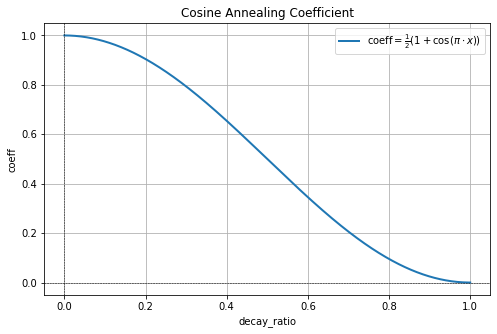

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 x (decay_ratio) 范围从 -1 到 1
x = np.linspace(0, 1, 1000)

# 计算 y (coeff)
y = 0.5 * (1 + np.cos(np.pi * x))

# 绘制曲线
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r'$\text{coeff} = \frac{1}{2} (1 + \cos(\pi \cdot x))$', linewidth=2)
plt.xlabel("decay_ratio")
plt.ylabel("coeff")
plt.title("Cosine Annealing Coefficient")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid()

# 显示图像
plt.show()

随着迭代的进行、明显decay_ratio越来越大、会引起余弦系数coeff越来越小。这个越来越小的值乘以$(\text{max\_lr} - \text{min\_lr})$，生成的值也越来越小，最终在整个公式上、引导学习率逐渐靠近设置好的$\text{min\_lr}$ ↓ 以此来实现衰减。

$$
\text{lr} = \text{min\_lr} +  (\text{max\_lr} - \text{min\_lr}) \times \frac{1}{2} \left(1 + \cos\left(\pi \cdot \text{decay\_ratio}\right)\right)
$$

<font color="red">**虽然余弦退火给人感受上是一个学习率降低的过程，但从代码实现的角度来说，却是在最低的learning_rate上逐渐降低比例的过程**</font>，假设规定的目标learning_rate是0.01，现在的学习率是0.05，那我们实现的其实是 ↓

<center>0.01 + (0.05-0.01) * 100%<br><br>
0.01 + (0.05-0.01) * 98%<br><br>
0.01 + (0.05-0.01) * 96%<br><br>
……

这样的下降过程。

---

- 线性预热 + 余弦退火的代码实现

In [10]:
def get_lr(it, all):
    warmup_iters = args.warmup_iters
    lr_decay_iters = all
    min_lr = args.learning_rate / 10

    if it < warmup_iters:
        return args.learning_rate * it / warmup_iters
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (args.learning_rate - min_lr)

代码说明 ↓

```python
def get_lr(it, all):
    # 获取当前学习率函数，输入参数为当前迭代步数 it 和总训练迭代步数 all

    warmup_iters = args.warmup_iters
    # 从参数中获取学习率预热的迭代步数（warmup_iters 表示预热阶段持续的迭代次数）

    lr_decay_iters = all
    # 设置学习率衰减的总迭代步数，通常等于训练的总迭代步数

    min_lr = args.learning_rate / 10
    # 设置最小学习率，通常是初始学习率的十分之一，表示学习率的下界

    if it < warmup_iters:
        # 如果当前迭代步数小于预热结束的步数，则处于学习率预热阶段
        return args.learning_rate * it / warmup_iters
        # 学习率从 0 线性增长到初始学习率 args.learning_rate

    if it > lr_decay_iters:
        # 如果当前迭代步数超过衰减的最大步数，说明已经进入训练末期
        return min_lr
        # 返回最小学习率，确保学习率不会进一步下降

    # 如果当前步数位于预热结束和衰减结束之间，则计算余弦退火学习率
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    # 计算衰减比例 decay_ratio，表示当前迭代步数在衰减阶段的相对进度
    # decay_ratio 的取值范围为 [0, 1]

    assert 0 <= decay_ratio <= 1
    # 断言：确保衰减比例在 [0, 1] 范围内，防止非法值导致错误

    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    # 使用余弦函数计算系数 coeff，该系数在 [1, 0] 之间变化
    # 初始时 coeff = 1（decay_ratio=0），逐渐衰减到 coeff = 0（decay_ratio=1）

    return min_lr + coeff * (args.learning_rate - min_lr)
    # 当前学习率等于最小学习率加上余弦系数与最大变化范围的乘积
    # 公式解释：学习率在最小学习率和初始学习率之间按照余弦函数平滑下降
```

同时我们还可以有更适应大型架构的、在预热之后将学习率保持一段时间、之后再进行退火的方案 ↓

```python
def get_lr_hold(it, all):
    warmup_iters = args.warmup_iters  # 预热迭代数
    hold_iters = int(0.1 * all)  # 设定一个保持阶段，比如总步数的10%
    lr_decay_iters = all - hold_iters  # 余弦衰减从这里开始
    min_lr = args.learning_rate / 10

    if it < warmup_iters:
        return args.learning_rate * it / warmup_iters  # 线性预热

    if it < warmup_iters + hold_iters:
        return args.learning_rate  # 保持高学习率一段时间

    decay_ratio = (it - warmup_iters - hold_iters) / (lr_decay_iters - warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    
    return min_lr + coeff * (args.learning_rate - min_lr)  # 余弦退火

### 2.4 模型初始化与断点续训机制

断点续训机制的意义在于保证深度学习模型在长时间训练过程中，即使因系统崩溃、设备重启或意外中断，也能从最近一次保存的状态继续训练，而无需从头开始。对于计算资源昂贵的深度学习任务，特别是大规模语言模型（LLM）或计算密集型任务，如计算机视觉和强化学习，断点续训可以有效减少训练时间和成本，提高训练的可靠性。

```python
#定义init_model函数、用于计算参数量、初始化模型参数、并且进行断点序训
def init_model():
    # 定义一个辅助函数，用于计算模型参数
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # 初始化 Transformer 模型，并将其移动到指定设备（CPU 或 GPU）
    # lm_config是设置在主程序中、从我们之前定义好的LMConfig()类中导入的所有参数
    # 而Transformer则是我们需要在model.py中定义好的包含全部流程的模型
    model = Transformer(lm_config).to(args.device)

    # 根据是否使用 Mixture of Experts (MoE) 机制，动态设置模型路径后缀
    moe_path = '_moe' if lm_config.use_moe else ''
    
    # 定义检查点路径（checkpoint_path），用于存储或加载模型
    # `args.save_dir` 是保存目录，`args.model_name` 是用户提供的模型名称
    checkpoint_path = f'{args.save_dir}/{args.model_name}.pth'

    # 如果存在已保存的模型检查点，则加载该模型
    if os.path.exists(checkpoint_path):
        # 记录日志，提示用户正在加载模型
        Logger(f"加载模型检查点 {checkpoint_path}")
        # 加载模型权重，并适配设备
        model.load_state_dict(torch.load(checkpoint_path, map_location=args.device))  
    else:
        # 如果不存在已经保存的检查点，则从头开始训练
        # 记录日志，提示用户将进行从零开始的训练
        Logger(f"没有找到模型检查点，开始从头训练")  
    
    # 计算并打印模型的总参数量（百万级别），方便查看模型规模
    Logger(f'LLM总参数量：{count_parameters(model) / 1e6:.3f} 百万')

    return model  # 返回初始化后的模型

```

### 2.5 预训练原理与预训练数据处理脚本

在之前的课程当中、我们为大家梳理了基于深度学习的基本训练流程——

---

<font color="red">**在定义好模型之后、深度学习训练的基本步骤与流程如下**——

1. **数据分批/打乱/分训练集验证集等操作、定义使用的CPU/GPU等细节**

2. **初始化模型参数（Parameter Initialization）**

3. **训练循环（training loop）**：
> **正向传播（Forward Pass）**：输入数据通过模型，得到预测输出。
> 
> **计算损失（Compute Loss）**：根据模型的预测结果和真实标签，计算损失函数值。
> 
> **反向传播（Backward Pass）**：根据损失函数的值，计算模型中各参数的梯度（使用自动微分）。
> 
> **参数更新（Update Parameters）**：根据计算出的梯度，使用优化器更新模型的参数。
> 
> **梯度清零（Zero Gradients）**：为了避免梯度累积，需要在每次迭代前将梯度归零。

4. **训练监控与模型保存**

---

在这个流程中，模型的迭代方向由“损失函数”决定，而损失函数是用于衡量真实可靠的答案与模型预测出的结果之间的差异，因此**从哪里获得真实可靠的答案、使用什么损失函数、怎么衡量模型预测出的结果是不是足够好**就成为深度学习流程中的核心问题之一。为模型设置正确的目标是所有训练的核心诉求、无论是深度学习、强化学习还是其他琳琅满目的学习方式都是如此。

常规来说，我们按照<font color="green">**真实标签容易获得的程度**</font>来划分、有以下两种最经典的学习模式 ↓

|任务类型|标签来源|适合的学习类型|适用的损失函数|
|:-:|:-:|:-:|:-:|
|图像识别、情感分类<br>年龄预测、双语翻译<br>信贷预测、行为预测|**标签是客观存在的**<br>只要人工标注上即可|有监督学习|交叉熵损失函数、MSE|
|文字生成、图像生成<br>图像降噪、客户分群<br>降维流程、异常检测|**一般没有绝对正确的标签，<br>只要合理即可**<br>或者标签很难标注出来、<br>根本不可能大批量获得|自监督或者<br>无监督学习|依具体任务而定|

因此不难发现、**<font color="green">每种不存在客观标签的任务都需要自己独特的学习流程</font>**，这也导致在文字生成这一领域我们有大量可用的训练方法。在文字生成领域中，无论我们希望文字完成什么任务，都要构建“对文字具备理解能力的模型”，下面介绍两种最常见的文字生成领域学习方法。

#### 2.5.1 两种文字模型的预训练方式

- **因果语言模型 Casual Language Model**

因果语言模型（Casual Language Model）是一种“对句子的下一个字进行预测”的自监督学习方法，它的基本流程如下：

1. 准备一段文字序列作为输入特征X，例如——

**<font color ="red"><center>竹外桃花三两枝，春江水暖鸭先知**

    在这个过程中，每个字/词生成一个词向量，作为一行。

2. 将序列向左移动一个单位作为标签y，例如——

**<font color ="red"><center>外桃花三两枝，春江水暖鸭先知**

    在这个过程中，每个字/词被编码成一个数字，作为一个标签。然而，由于序列向左移动了一个单位，因此整个句子比原来的序列少了一个字，为了让特征X与标签y能够匹配，我们往往会删除特征X中的最后一个token，将结构转变为 ↓
    
**<font color ="red"><center>X ：竹外桃花三两枝，春江水暖鸭先<br>Y ：外桃花三两枝，春江水暖鸭先知**

3. 让每一个字/词结合自己前面所有的字、预测下一个字/词，**对比模型生成的下一个词的编号和真实的下一个词的编号之间的差异**，以此来计算损失函数，并逼迫模型理解语义。

这就是GPT等当代大语言模型所采用的自监督学习方式，也**几乎是所有生成模型所采用预训练方式，它被称为“自回归预测”**。这个方式不需要人工打标签，**且每次推理只能输出一个字**。因此对大语言模型来说，要想输出一句话、一个段落，就需要对模型生成过程进行循环。

需要注意的是，在这个过程中，编码后的数据呈现为 ↓ 

|token|embd1|embd2|...|embd_dim|
|:-:  |:-:  |:-:  |:-:|:-:|
|竹|...|...|...|...|...|
|外|...|...|...|...|...|
|桃|...|...|...|...|...|
|花|...|...|...|...|...|
|三|...|...|...|...|...|

这个矩阵在经过带**前瞻掩码的注意力机制**之后会转变为 ↓

|token|embd1|embd2|...|embd_dim|
|:-:  |:-:  |:-:  |:-:|:-:|
|竹|...|...|...|...|...|
|竹外|...|...|...|...|...|
|竹外桃|...|...|...|...|...|
|竹外桃花|...|...|...|...|...|
|竹外桃花三|...|...|...|...|...|

因此GPT等大语言模型是在用“前半部分句子”预测下一个词、而不是用上一个词预测下一个词。在最终的计算过程中、为了对比模型预测的“下一个词”和“真实的下一个词”之间的差异，我们计算的实际是模型预测出的词的编号与真实的下一个词的编号之间的差异、本质就是计算类别的差异，因此我们使用的是分类算法中常见的**多分类交叉熵损失**作为损失函数。

- **掩码语言模型 Masked Language Model**

掩码语言模型（Masked Language Model）是一种“把句子的中间词掩盖掉、让模型预测被掩盖的词”的自监督学习方法，它的基本流程如下：

1. 准备一段文字序列，例如——

**<font color ="red"><center>竹外桃花三两枝，春江水暖鸭先知**

2. 在序列中随机掩盖一些词、形成带掩码的序列、作为模型的输入X，例如——

**<font color ="red"><center>竹外[masked]花三两[masked]，[masked]江水暖[masked]先知**

在这个过程中，每个字/词生成一个词向量，作为一行。<br><br>

3. 使用掩码前的文字序列作为标签y，在这个过程中，每个字/词都转化成一个字，作为标签。<br><br>

4. 将上述掩码后的句子X放入注意力机制，**取消前瞻掩码、并在生成的所有行中、只计算被masked掉的行的损失函数**，以此来逼迫模型理解语义。

具体地来说，经过掩码后、编码的数据呈现为 ↓

|token|embd1|embd2|...|embd_dim|
|:-:  |:-:  |:-:  |:-:|:-:|
|竹|...|...|...|...|...|
|外|...|...|...|...|...|
|[masked]|...|...|...|...|...|
|花|...|...|...|...|...|
|三|...|...|...|...|...|

由于进行前瞻掩码、所以经过多头注意力机制后、所有行都可以获得上下文信息（相比之下、带前瞻掩码的注意机制输出的结果中、每行只能获得上文信息、不能获得下文信息）。因此在掩码语言模型的注意力机制中我们会得到——

|token|embd1|embd2|...|embd_dim|
|:-:  |:-:  |:-:  |:-:|:-:|
|竹外 [MASK] 花三两 [MASK]，[MASK] 江水暖 [MASK] 先知|...|...|...|...|...|
|竹外 [MASK] 花三两 [MASK]，[MASK] 江水暖 [MASK] 先知|...|...|...|...|...|
|竹外 [MASK] 花三两 [MASK]，[MASK] 江水暖 [MASK] 先知|...|...|...|...|...|
|竹外 [MASK] 花三两 [MASK]，[MASK] 江水暖 [MASK] 先知|...|...|...|...|...|
|竹外 [MASK] 花三两 [MASK]，[MASK] 江水暖 [MASK] 先知|...|...|...|...|...|

然后我们再从这个序列中、只取第3、第6、第9、第13行出来与原始未掩码的序列的第3、第6、第9、第13行计算损失，其他行的结果就不再计算。同样，我们考虑的是“模型预测出的字”和“被掩码的真实的字”之间的差异，因此本质还是计算编号与编号的差异、因此掩码语言模型使用的也依然是**多分类交叉熵损失函数**。

这就是掩码语言模型的预训练方式，如你所见，这个流程中输出的并不是“下一个字”，因此也不能用于文字生成任务，大部分时候掩码语言模型预训练被用于训练“文字理解算法”，这样训练出来的模型能够很好地理解上下文、但不能对文字进行回应。因此这样的算法常常被我们接上“输出层”来完成基于文字理解的有监督任务。

**为什么在看实际的预训练代码之前，我们要讲解不同的预训练流程呢**？不难发现，不同的预训练流程提供的输入数据X和标签y不同，同时可能存在不同的损失函数，如果不理解预训练流程、我们就无法完成数据的划分、标签的划分、更无法设置损失函数、完成最终的训练脚本。

In [ ]:
raw data ==> 去重、火星文、广告/暴力涩情/脏话/低俗、构建算法来进行祛毒、繁体/简体字、乱码、链接、图像
分块/压缩/打包 ==> jsonl/parquet/csv + 多线程并行数据拉取
jsonl（错误检查、筛选） ==> bin、parquet
分词（tokenzier）、编码（0,1,2,3,4），样本化(X,y)，嵌入（embedding）


样本化(X,y)  ==> 分割整理 (batch_size, seq_len)、Tensor化、加载方式、存储方式、能够跟分布式预训练配合的一系列设置


Dataset.py

#### 2.5.2 因果语言模型的数据处理方法

在之前的课程中、我们已经对原始的JSONL数据进行了处理，我们检查了其有效性、并且将JSONL转变成了更高效的二进制bin文件进行存储。现在我们距离将数据放入预训练架构中仅有一步之遥。通常、在进行真正的预训练之前，我们需要定义**继承自pytorch的Dataset或者继承自transformers的PretrainedDataset**的类帮助我们确认单个样本的加载流程，同时还会需要**Pytorch中所规定的Dataloader**类帮助我们定义一整个批次数据的加载流程，最后再加上分布式的数据处理技巧，三重规则帮助我们一起实现数据的整合。

在本次续联中，这个**继承自Dataset**的类被我们命名为`PretrainDataset`。在`PretrainDataset`中，除了定义数据的加载方式，我们还需要将数据明确与PyTorch、Transformers、DeepSpeed、Megatron-LM等分部署框架的需求链接起来、还需要定义单一样本的具体样式。具体地来说，在我们自定义的`PretrainDataset`中，我们需要对数据做出以下的处理：

- **明确数据加载方式**

数据的加载方式决定了内存占用和数据访问速度，因此在训练中需要慎重考虑。**通常我们谈到数据加载，是指从硬盘中将数据加载到CPU内存或GPU显存的过程**。对任意大模型而言，在数据加载流程中，我们需要有以下设置——

1. **支持多文件载入的设置**。大部分大语言模型训练的数据都不是一个jsonl或bin文件，而是很多文件共同构成数据集 ↓ ，有时候我们甚至需要将多个文件中加载的内容合并成一个批次或一个样本，因此我们的`PretrainDataset`需要支持多文件一次性加载（尽管在MateConv Mini中我们加载的是一个文件）。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/28.png)

2. **支持memmap进行磁盘映射加载的设置**。文件有很多种加载形式，最简单的pd.read_csv可以加载文件、pyarrow、dask也可以分布式超快速加载文件，而对于巨型的jsonl数据、我们需要依赖于磁盘映射加载。**磁盘映射是一种按需加载（Lazy Loading）机制，它只在磁盘中创建内存映射、允许我们访问小部分数据、但实际上并不把数据加载到内存或显存中**。

    当我们使用较小的数据集和普通数据加载方式时，在实例化`PretrainDataset`类的时候、全体数据集就会被加载到内存/显存中（通常默认加载到CPU的内存RAM中）；而当我们使用`memmap`进行加载时、只会在RAM中创建很小的内存映射，数据不会真正被放入内存中。只有当我们开始进行训练循环、需要把数据放置到GPU上时，数据才会真正地按批次被加载进来、这样就可以避免OOM错误的产生。这个操作在计算机视觉的世界中非常常见、毕竟视觉数据（无论是图像还是视频）的内存占用都非常可怕。

    当然，如果不把数据真正加载到内存中、就会产生交互问题。在传统加载时，我们需要的是内存到显存的信息交互，但使用`memmap`时，我们需要的是硬盘到显存的交互，因此会收到硬盘I/O限制，因此加载速度会相对较慢。

| 加载方式  | 适用数据规模 | 内存使用 | 访问速度 | 适用场景 |
|-----------|-----------|-----------|-----------|-----------|
| **`memmap=True`** | TB 级大数据 | 低（仅映射） | 适中（磁盘 I/O 依赖） | 大规模分布式训练 |
| **`memmap=False`** | 小～中等规模（几十 GB） | 高（全加载） | 快（RAM 访问） | 本地 GPU 训练 |

    如果数据格式是 **多个 JSONL 或 Parquet 文件**，我们通常先**处理成二进制格式（如 `.bin`）**，这样可以直接使用 `np.fromfile()` 或 `np.memmap()` 进行高效加载了。

如果数据规模过大，还可以**从远程存储（如 S3、HDFS）进行流式加载**等更先进的技术来避免本地存储压力，Huggingface中的load_dataset就支持流式加载。

3. **在加载的同时对数据进行形状调整、为后续分批次做准备**。通常来说，我们会规定一个批次中的`max_seq_len`，并按照该`max_seq_len`的倍数来取给到模型的token总数，这样所有的token就可以被均匀划分成具体的批次了。在DeepSpeed/Megatron-LM进行预训练时，我们通常倾向于使用静态的batch_size和静态的seq_len，因此在对数据进行准备的时候就可以直接分好`max_seq_len`。

In [1]:
import json
import random
import re

import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

class PretrainDataset(Dataset):
    # 在代码的init部分，就需要定义数据的载入形式
    # 需要输入的参数是，数据所在目录、最大的seq_len，以及是否进行memmap映射
    def __init__(self, data_path_lst, max_length=512, memmap=False):
        super().__init__()

        if memmap:
            # 如果是使用memmap模式，则使用np.memmap进行加载
            # 并且只导入第一个文件、按照该文件的格式对数据格式进行修改
            with open(data_path_lst[0], 'r') as f:
                # 把指针移动到文件夹末尾、获取文件的字节大小
                # 通过总字节大小除以uint16元素字节的方式
                # 计算一共有多少个uint16元素，也就是计算一共有多少token
                # 在控制结构的时候，用总token整除max_length
                nbytes = f.seek(0, 2)
                flen = f.tell() // np.dtype('uint16').itemsize
            self.data = np.memmap(data_path_lst[0], dtype=np.dtype('uint16')
                                  , shape=(flen // max_length, max_length))
        else:
            # 如果不是memmap模式，那就一次性读入目录中所有文件（np.fromfile）
            data_lst = []
            for data_path in data_path_lst:
                with open(data_path, 'rb') as f:
                    # 读入的格式是unit16，并且将所有数据保存在列表中
                    data = np.fromfile(f, dtype=np.uint16)
                    data_lst.append(data)
            # 对数据进行合并、所有token链接在一起，依据token进行max_length划分
            data = np.concatenate(data_lst)
            data = data[:max_length * int(len(data) / max_length)]
            # np.random.shuffle(data)
            # 这里的-1就是分好的batch_size了
            self.data = data.reshape(-1, max_length)
        print("memmap:{} train data.shape:{}".format(memmap, self.data.shape))
        print("downloading finished.....")

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index: int):
        sample = self.data[index]
        X = np.array(sample[:-1]).astype(np.int64)
        Y = np.array(sample[1:]).astype(np.int64)

        return torch.from_numpy(X), torch.from_numpy(Y)

除了定义数据加载方式、并且对格式进行规定之外，在`PretrainDataset`中我们还需要关注 ↓

- **`__len__`与`__getitem__`方法的实现**

`__len__()`是返回`return self.data.shape[0]` 或 `return len(self.data)`的内部方法，为 `DataLoader` 提供争取的token综述、确保`Dataloader`能正确计算 `batch_size`。

`__getitem__()`则是定义单个样本结构、并按索引获取单个样本的内部方法。其输入的数据通常是 **Token ID**，形如 `[101, 2345, 6789, 102]`。一般来说，对当我们运行`dataloader`类时，`dataloader`会按照`__getitem__()`中定义的方法将模型批量取出。

这两个内部类为`dataloader`提供的支持确保了数据可以被用于任何依托于`dataloader`的框架，例如DeepSpeed和Megatron-LM。

由于`__getitem__()`中需要定义单个样本的结构，因此我们一般需要在`__getitem__()`内部完成数据整理，比如分割数据中的X和y，对数据添加适合的掩码、如果需要的话、对较短的序列进行Padding填充、对较长的序列进行Truncation截断等等。`__getitem()`还可以与 Hugging Face中的`collate_fn`联用、对数据进行更细致的定义和处理。在本次预训练中我们的数据比较规整、因此本次`__getitm__()`定义较为简单 ↓ 

In [ ]:
import json
import random
import re

import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

class PretrainDataset(Dataset):
    def __init__(self, data_path_lst, max_length=512, memmap=False):
        super().__init__()

        if memmap:
            with open(data_path_lst[0], 'r') as f:
                nbytes = f.seek(0, 2)
                flen = f.tell() // np.dtype('uint16').itemsize
            self.data = np.memmap(data_path_lst[0], dtype=np.dtype('uint16')
                                  , shape=(flen // max_length, max_length))
        else:
            data_lst = []
            for data_path in data_path_lst:
                with open(data_path, 'rb') as f:
                    data = np.fromfile(f, dtype=np.uint16)
                    data_lst.append(data)
            data = np.concatenate(data_lst)
            data = data[:max_length * int(len(data) / max_length)]
            self.data = data.reshape(-1, max_length)
        print("memmap:{} train data.shape:{}".format(memmap, self.data.shape))
        print("downloading finished.....")

    def __len__(self):
        # 读取数据的shape[0]，也就是之前读取的总token数
        return self.data.shape[0]

    def __getitem__(self, index: int):
        # 允许输入索引的编号、对数据进行索引
        sample = self.data[index]
        
        # 按照因果语言模型的模式、最后一个字之前的所有字是X
        # 并且按照int64进行编码
        X = np.array(sample[:-1]).astype(np.int64)
        # 向左移动一个单位、整个序列作为y
        # 并且按照int64进行编码
        Y = np.array(sample[1:]).astype(np.int64)

        return torch.from_numpy(X), torch.from_numpy(Y)

这段代码被我们单独编码为`Dataset.py`脚本，并放置在model文件夹下 ↓ 。和这个py文件放在一起的还有之前我们定义的model.py以及模型的参数文件LMConfig.py。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/93.png)

你可能发现了，在Dataset.py中我们没有设置分布式的支持，这是因为加载数据用的`torch.distributed`等工具可以和`PretrainDataset`类同级来进行使用，因此我们将在预训练的脚本中配置分布式相关的信息。

### 2.6 预训练主程序与主流程深度解析

在某些 Python 脚本中，我们会设置一段以`if __name__ == "__main__"`开头的代码，这段代码存在代表着当前Python脚本可以作为一个主程序被使用（直接在CLI中与deepspeed命令或者Megatron-LM命令联合使用），也可以被作为一个import到其他脚本中的library来使用。

作为主程序使用时——

```shell
deepspeed --master_port 29500 --num_gpus=4 pretrain.py --epochs 30
```

作为导入的library来使用时——

```python
from pretrain import get_lr
```

当这段脚本以被导入的library来使用时，只会运行脚本中定义的各个函数与类，但当这段脚本以主程序方式运行时，除了运行脚本中定义的各个函数、类之外，还会运行`if __name__ == "__main__"`下定义的内容。因此，**`if __name__ == "__main__"`可以被认为是主程序中最核心的、最上层的程序，它会关联到所有已经定义好的模块、并完成综合性的任务**。因此，它往往也是所有程序中嵌入层次最多、复杂程度最高的代码。

在我们整个预训练的脚本中，我们有如下代码 ↓ 它覆盖了以下的全部11个流程：


| **步骤编号** | **流程名称**                    | **关键操作** |
|-----------|----------------------------|----------|
| **1️⃣** | **解析命令行参数**（argparse）  | 读取超参数 |
| **2️⃣** | **创建存储目录 & Checkpoint**  | 确保模型存储路径 |
| **3️⃣** | **设置设备 & 随机种子**         | 确保可复现性 |
| **4️⃣** | **初始化 WandB**              | 远程监控训练 |
| **5️⃣** | **开启混合精度训练（AMP）**    | autocast + GradScaler |
| **6️⃣** | **分布式训练（DDP）**          | 多 GPU 训练 |
| **7️⃣** | **数据加载（DataLoader）**      | 并行数据加载 |
| **8️⃣** | **模型 & 优化器初始化**        | Adam 优化器 |
| **9️⃣** | **恢复 Checkpoint**            | 断点续训 |
| **🔟** | **编译模型（Torch 2.0）**      | 提升计算速度 |
| **1️⃣1️⃣** | **训练循环**（train_epoch）    | 实现多轮训练 |

让我们来看一下关键的代码设置 ↓

```python
import argparse #解析并设置命令行参数的库
import torch
import os
import platform
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel
from contextlib import nullcontext
import torch.optim as optim

#############
# 解析命令行参数
#############
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="MateConv Pretraining")
    
    # 训练参数、包括模型输出目录
    parser.add_argument("--out_dir", type=str, default="out", help="Output directory")
    parser.add_argument("--epochs", type=int, default=20, help="Number of epochs")
    parser.add_argument("--batch_size", type=int, default=32, help="Batch size")
    parser.add_argument("--learning_rate", type=float, default=2e-4, help="Learning rate")
    
    # 设备与精度相关参数
    parser.add_argument("--device", type=str, default="cuda:0" if torch.cuda.is_available() else "cpu", help="Device to use")
    parser.add_argument("--dtype", type=str, default="bfloat16", help="Data type")
    
    # 监控与日志记录
    # 这里如果使用WandB、则可以在WandB页面同步查看到模型迭代的损失函数曲线
    parser.add_argument("--use_wandb", action="store_true", help="Use Weights & Biases")
    parser.add_argument("--wandb_project", type=str, default="MateConv-Pretrain", help="Weights & Biases project name")
    
    # 数据加载相关参数
    parser.add_argument("--num_workers", type=int, default=8, help="Number of workers for data loading")
    parser.add_argument("--data_path", type=str, default="./dataset/pretrain_data.bin", help="Path to training data")
    
    # 分布式训练相关参数
    parser.add_argument("--ddp", action="store_true", help="Use DistributedDataParallel")
    parser.add_argument("--local_rank", type=int, default=-1, help="Local rank for distributed training")
    
    # 训练细节
    # 梯度累积技术
    parser.add_argument("--accumulation_steps", type=int, default=8, help="Gradient accumulation steps")
    # 梯度裁剪技术
    parser.add_argument("--grad_clip", type=float, default=1.0, help="Gradient clipping threshold")
    # lr线性预热技术
    parser.add_argument("--warmup_iters", type=int, default=0, help="Number of warmup iterations")
    
    # 日志与模型存储
    parser.add_argument("--log_interval", type=int, default=100, help="Logging interval")
    parser.add_argument("--save_interval", type=int, default=1000, help="Model saving interval")
    parser.add_argument("--model_name", type=str, default="pretrain_512", help="模型名称，用于保存和加载检查点")

    args = parser.parse_args()

#############
# 目录与检查点管理
#############
    lm_config = LMConfig()
    max_seq_len = lm_config.max_seq_len
    args.save_dir = os.path.join(args.out_dir)
    os.makedirs(args.save_dir, exist_ok=True)
    os.makedirs(args.out_dir, exist_ok=True)
    checkpoint_path = f'{args.save_dir}/{args.model_name}.pth'

#############
# 设备与计算环境设置
#############
    tokens_per_iter = args.batch_size * max_seq_len
    torch.manual_seed(1337)
    device_type = "cuda" if "cuda" in args.device else "cpu"

#############
# Weights & Biases 配置
#############
    
    # 设置W&B所保存的project的名称
    args.wandb_run_name = f"MateConv-Pretrain-Epoch-{args.epochs}-BatchSize-{args.batch_size}-LearningRate-{args.learning_rate}"
    
    # WandB初始化
    if args.use_wandb and (not ddp or ddp_local_rank == 0):
        import wandb
        wandb.init(project=args.wandb_project, name=args.wandb_run_name)
    else:
        wandb = None
    
#############
# 混合精度训练配置
#############
    
    # 初始化混合精度训练的条件
    # 如果设备是gpu的话就使用混合精度训练
    # 并且使用autocast()来自动决定某些操作应该使用的精度
    ctx = nullcontext() if device_type == "cpu" else torch.cuda.amp.autocast()

    # 初始化梯度缩放器GradScaler、这里的缩放其实是放大
    # 在精度为float16和bf16的时候、启动梯度缩放（乘以一个放大因子）
    # 如果是其他更大的精度（比如float32），则不启动缩放
    scaler = torch.cuda.amp.GradScaler(enabled=(args.dtype in ['float16', 'bfloat16']))
    
#############
# 分布式训练设置
#############

    # 从环境变量中取出rank，如果是-1则没有DDP
    ddp = int(os.environ.get("RANK", -1)) != -1  # 是否为 DDP 运行

    # 将主设备编号设置为0
    ddp_local_rank, DEVICE = 0, "cuda:0"
    
    if ddp:
        # 给设备开启分布式模式
        init_distributed_mode()
        args.device = torch.device(DEVICE)
        
        # 在模型中执行分布式数据并行
        model._ddp_params_and_buffers_to_ignore = {"pos_cis"}
        model = DistributedDataParallel(model, device_ids=[ddp_local_rank])

#############
# 数据加载
#############
    # 从目录加载文件list
    data_path_list = [args.data_path]
    # 用PretrainDataset加载文件
    train_ds = PretrainDataset(data_path_list, max_length=max_seq_len, memmap=True)

    # 对文件进行数据并行的分布式划分
    # 确保每个GPU只加载属于自己的数据子集
    train_sampler = DistributedSampler(train_ds) if ddp else None

    # 使用Dataloader对数据进行划分
    train_loader = DataLoader(
        train_ds,
        batch_size=args.batch_size,
        pin_memory=True,
        drop_last=False, # 保证所有batch_size中的样本数量相同
        shuffle=False,
        # 每个GPU进程用多个worker线程来并行加载数据
        num_workers=args.num_workers, 
        sampler=train_sampler
    )

#############
# 模型初始化、优化器初始化
#############
    model = init_model()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

#############
#  恢复优化器状态（如果存在现有的checkpoint）
#############
    optimizer_state_path = f'{args.save_dir}/{args.model_name}_optimizer.pth'
    if os.path.exists(checkpoint_path):
        if os.path.exists(optimizer_state_path):
            Logger(f"加载优化器状态 {optimizer_state_path}")
            optimizer.load_state_dict(torch.load(optimizer_state_path, map_location=args.device))
        else:
            Logger(f"没有找到优化器状态，使用新的优化器")

#############
# 编译模型（如果支持 Torch 2.0）
#############
    if False and platform.system() != 'Windows' and float(torch.__version__.split('.')[0]) >= 2:
        Logger("compiling the model... (takes a ~minute)")
        unoptimized_model = model
        model = torch.compile(model)

#############
# 训练循环
#############
    iter_per_epoch = len(train_loader)
    for epoch in range(args.epochs):
        train_epoch(epoch, wandb)
```

#### 2.6.1 混合精度训练MTP与量化

在神经网络的训练流程中，**不同的计算过程对数值精度的需求不同**。一般来说，计算量大的部分，如 **前向传播（Forward Pass）** 和 **反向传播中的梯度计算**，可以容忍低精度，而**权重更新（Optimizer Update）** 等等流程则需要更高精度来保持数值稳定性。在大模型续联中、数据的精度越高计算负担越大、同时对内存的要求也会越高，因此**我们可以通过在不同的阶段使用不同的精度来实现计算效率/存储效率与计算精度的平衡，这也是混合精度训练的核心概念**。

我们可以按照是否对高精度有需求将训练流程如下划分 ↓

---

**<center>神经网络经典计算流程精度需求表** 

🟢 **低精度**（float16 / bfloat16 ）：一般来说、计算量很大的部分我们愿意牺牲精度换取效率

🔴 **高精度**（float32）：对稳定性要求很高的部分、我们则会保持高精度、牺牲效率

| **计算流程**                      | **精度需求**          | **原因** |
|----------------------------------|---------------------|--------|
| **前向传播（Forward Pass）**      | 🟢 **低精度（FP16或BF16）** | 计算量大，FP16 可以提高吞吐量并减少显存使用 |
| **矩阵乘法（GEMM，线性层）**     | 🟢 **低精度（FP16或BF16）** | 计算密集型操作，FP16 提升计算效率 |
| **激活函数（ReLU, GELU）**      | 🟢 **低精度（FP16或BF16）** | 计算量大，对数值精度不敏感 |
| **反向传播（Backward Pass）** | 🟢 **低精度（FP16或BF16）** | 包括计算图中所有的张量（中间变量、激活值、权重等）的梯度，都可以容忍较低的精度。 |
| **权重存储（Model Weights）**    | 🟢 **低精度（FP16或BF16）** | 低精度存储权重，减少显存占用 |
| **权重梯度（Weight Gradient）** | 🟢 **低精度（FP16或BF16）** | 最后用于迭代的梯度，可以使用低精度 |
| **损失计算（Loss Computation）** | 🔴 **高精度（FP32）** | 需要较高数值稳定性，使用 FP32 进行累积 |
| **MoE 门控（MoE Gating）**        | 🔴 **高精度（FP32）** | MoE 门控机制对精度要求高 |
| **注意力计算（Attention Mechanism）** | 🔴 **高精度（FP32 / BF16）** | 注意力机制对精度要求高，低精度可能不稳定 |
| **Softmax / LogSoftmax**        | 🔴 **高精度（FP32）** | 低精度可能导致 underflow，使用 FP32 计算 |
| **指数运算（Exp）**              | 🔴 **高精度（FP32）** | 低精度可能导致溢出或 underflow |
| **归一化（BatchNorm / LayerNorm）** | 🔴 **高精度（FP32 / BF16）** | 低精度导致不稳定，保持 FP32 或 BF16 |

---

- **那不同流程中的精度一般是如何相互切换的呢**？

通常我们会给输入数据（保存的数据）一个具体的梯度、在进行计算之前、会对该梯度进行调整、可能上升到更高的精度进行计算、计算结束后又再下调回原来的精度。从高精度下调到低精度的做法就是**量化Quantization**，而从低精度上升到高精度的做法就是**解量化 Dequantization**。

<font color="red">**<center>精度由数据可覆盖的范围大小、以及该范围内每个数据点之间的间隔大小共同决定。**

例如——

<center>[1,2,3,4,5] 的范围 小于 [1,2,3,4,5,6,7,8,9,10] 的范围
    <br><br>
<center>[1,2,3,4,5] 的间隔 大于 [1.1,1.2,1.3,1.4,1.5] 的间隔

在计算机的定义中、可表示的范围越大精度就越高、同时数字之间间隔越小（分辨率越高）、精度就越高，可惜范围大和间隔小不总能同时达成，如果一个数据格式**范围广且间隔小，那这个数据格式占用的内存就大**。因此，内存、范围和间隔是无法都实现的。量化和解量化这个过程的本质是**改变数据映射范围大小、以及改变数据表示的分辨率**、而非单纯的改变数据格式。BF16和FP16虽然看起来都是16位的表示方式，但是BF16表示范围更大、FP16表示更精细，在数据量巨大的大语言模型训练流程中，BF16优势更大。

**量化与解量化的过程可以被简单表示为**——

- **量化（Quantization）**：除以缩放因子并进行离散化、将数字映射到更小的动态范围。
  $$
  x_q = \text{round}(x / s).to(低精度)
  $$
  其中：
  - $ x_q $ 是 **低精度量化权重**
  - $ x $ 是 **高精度原始权重**
  - $ s $ 是 **缩放因子（scale factor）**

- **解量化（Dequantization）**：乘以缩放因子，将数字映射到更大的动态范围。
  $$
  x = (x_q \times s).to(高精度)
  $$
  其中：
  - $ x_q $ 是 **存储的低精度量化权重**
  - $ s $ 是 **量化时使用的缩放因子**
  - $ x $ 是 **恢复的高精度权重**

很多量化过程的本质正是基于这个公式，逐块（block-wise）地执行量化和解量化。

#### 2.6.2 梯度累积与梯度裁剪技术

- **梯度累积**

**梯度累积** 是一种 **在多个小批次（mini-batches）上累积梯度**，然后再进行一次优化器更新的技术。它的主要目的是 **模拟更大的 batch size**，在显存受限的情况下提高训练稳定性和效果。

---

<font color="red">**在定义好模型之后、深度学习训练的基本步骤与流程如下**——

1. **数据分批/打乱/分训练集验证集等操作、定义使用的CPU/GPU等细节**

2. **初始化模型参数（Parameter Initialization）**

3. **训练循环（training loop）**：
> **正向传播（Forward Pass）**：输入数据通过模型，得到预测输出。
> 
> **计算损失（Compute Loss）**：根据模型的预测结果和真实标签，计算损失函数值。
> 
> **反向传播（Backward Pass）**：根据损失函数的值，计算模型中各参数的梯度（使用自动微分）。
> 
> **参数更新（Update Parameters）**：根据计算出的梯度，使用优化器更新模型的参数。
> 
> **梯度清零（Zero Gradients）**：为了避免梯度累积，需要在每次迭代前将梯度归零。

4. **训练监控与模型保存**

---

梯度累积就是在多个批次中取消梯度清零这一步、让多个小批次的梯度**不会立即清零**，而是累积起来。直到累积了一定数量（`accumulation_steps`）的小批次后，才执行一次优化器更新（optimizer.step()）。这适合于batch_size不足时的情况、在多个batch上积累了梯度后再进行迭代，可以让迭代更加稳定。

📌 示例代码：
```python
accumulation_steps = 4  # 4 个小批次累积一次更新
for step, (inputs, targets) in enumerate(data_loader):
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    
    loss.backward()  # 计算梯度但不更新参数
    
    if (step + 1) % accumulation_steps == 0:  # 每 4 个 step 进行一次参数更新
        optimizer.step()
        optimizer.zero_grad()  # 清空梯度，准备下一次累积
```

---

- **梯度裁剪**

**梯度裁剪** 是一种 **防止梯度爆炸**（gradient explosion）的技术，它通过限制梯度的最大范数或绝对值，**避免参数更新过大，导致训练不稳定**。它主要用于梯度下降时，梯度过大可能导致损失（loss）发散的情况，通过设定梯度最大值或梯度范数上限，将超过阈值的梯度缩小。

📌 **示例代码**：
```python
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 限制梯度范数
```
或
```python
torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.5)  # 限制梯度绝对值
```

**<center>改善精度的计算流程（混合精度 / 额外优化）精度需求表**

🟢 **低精度**（float16 / bfloat16 / ）  
🔴 **高精度**（float32）  

| **计算流程**                      | **精度需求**          | **原因** |
|----------------------------------|---------------------|--------|
| **梯度累积（Gradient Accumulation）** | 🔴 **高精度（FP32）** | 需要高精度累积，避免精度下溢 |
| **优化器裁剪（Gradient Clip）** | 🔴 **高精度（FP32）** |  需要高精度裁剪，这样才能保持梯度更稳定 |

### 2.7 单epoch预训练函数深度解析

这个函数的作用是 **实现深度学习模型的单个 epoch 的训练过程**，涵盖了从数据加载、前向传播、损失计算、反向传播、学习率调整到模型保存的完整逻辑。它实现了对训练集的所有数据（分为多个批次）进行一轮完整训练，包括了下面所有这些板块——

| **模块** | **主要作用** |
|----------------|----------------|
| **1. 训练循环** | 遍历 `train_loader`，训练多个 epoch |
| **2. 数据加载** | 通过 `to(args.device)` 将数据送入 GPU/CPU |
| **3. 学习率调整** | `get_lr()` 计算动态学习率|
| **4. 前向传播** | `model(X, Y)` 计算预测值 `out` 和损失 |
| **5. 反向传播** | `scaler.scale(loss).backward()` 计算梯度 |
| **6. 训练日志** | `Logger()` 记录损失、学习率等信息（支持 `wandb`） |
| **7. 模型保存** | `torch.save()` 仅在主进程（rank 0）保存模型和优化器 |
| **8. 备份优化器** | `torch.save(optimizer.state_dict())` 以支持断点续训 |

在这些板块中、还实现了**累积梯度**、**分布式支持**、**混合精度训练**等优化流程。

```python
#############
# 训练单个 Epoch
#############
def train_epoch(epoch, wandb):
    start_time = time.time()

    #############
    # 遍历 Mini-Batches
    #############
    for step, (X, Y) in enumerate(train_loader):
        X = X.to(args.device)
        Y = Y.to(args.device)

        #############
        # 学习率调整（LR Scheduling）
        #############
        lr = get_lr(epoch * iter_per_epoch + step, args.epochs * iter_per_epoch)
        
        # Adam优化算法会将参数分组、按组进行学习率调整
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        #############
        # 前向传播（Forward Pass） & 计算 Loss
        # 混合精度计算AMP
        #############
        with ctx:
            out = model(X, Y)
            # 归一化 loss 以适应梯度累积
            # 在之前计算的几次loss中、梯度都没有迭代
            # 因此相比起正常迭代的梯度，loss应该会偏高
            # 因此需要用损失/累积梯度的迭代次数来得到当前权重下的平均损失
            loss = out.last_loss / args.accumulation_steps  

        #############
        # 反向传播（Backward Pass） - 梯度计算
        # 使用 GradScaler 进行梯度缩放，防止 underflow
        #############
        scaler.scale(loss).backward()  

        #############
        # 梯度累积 & 梯度裁剪
        #############
        # 累积到一定梯度后、才进行迭代
        if (step + 1) % args.accumulation_steps == 0:
            # 解除缩放，转换回 FP32
            scaler.unscale_(optimizer)  
            # 进行梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.grad_clip)  

            #############
            # 参数更新（Optimizer Step）
            #############
            scaler.step(optimizer)  # 使用 FP32 进行优化器更新
            scaler.update()  # 动态调整梯度缩放因子

            #############
            # 清空梯度（Zero Grad）
            #############
            optimizer.zero_grad(set_to_none=True)  # 释放显存，减少计算开销

        #############
        # 日志记录 & 监控（Logging & Monitoring）
        #############
        if step % args.log_interval == 0:
            spend_time = time.time() - start_time
            Logger(
                'Epoch:[{}/{}]({}/{}) loss:{:.3f} lr:{:.7f} epoch_Time:{}min:'.format(
                    epoch,
                    args.epochs,
                    step,
                    iter_per_epoch,
                    loss.item() * args.accumulation_steps,  # 还原 loss
                    optimizer.param_groups[-1]['lr'],
                    spend_time / (step + 1) * iter_per_epoch // 60 - spend_time // 60))

            #############
            # WandB 记录（可视化监控）
            #############
            if (wandb is not None) and (not ddp or dist.get_rank() == 0):
                wandb.log({"loss": loss.item() * args.accumulation_steps,
                           "lr": optimizer.param_groups[-1]['lr'],
                           "epoch_Time": spend_time / (step + 1) * iter_per_epoch // 60 - spend_time // 60})

        #############
        # 模型检查点保存（Checkpointing）
        #############
        if (step + 1) % args.save_interval == 0 and (not ddp or dist.get_rank() == 0):
            model.eval()  # 切换到评估模式，避免 BN 层更新
            moe_path = '_moe' if lm_config.use_moe else ''
            ckp = f'{args.save_dir}/{args.model_name}.pth'  # 用户提供的模型名称

            #############
            # 保存模型权重
            #############
            if isinstance(model, torch.nn.parallel.DistributedDataParallel):
                state_dict = model.module.state_dict()  # DDP 模型需要 `.module` 获取权重
            else:
                state_dict = model.state_dict()

            torch.save(state_dict, ckp)
            Logger(f"保存模型到 {ckp}")

            #############
            # 保存优化器状态
            #############
            optimizer_state_path = f'{args.save_dir}/{args.model_name}_optimizer.pth'
            torch.save(optimizer.state_dict(), optimizer_state_path)
            Logger(f"保存优化器状态到 {optimizer_state_path}")

            model.train()  # 重新切换回训练模式
```

到目前为止，我们实现了以下的全部流程、构成了完整的pretrain.py脚本 ↓

1. **定义各个功能模块（函数）**<br><br>
   - 这些函数是 **独立的、可复用的功能单元**，包括：<br><br>
     - `Logger()` → 负责日志记录
     - `get_lr()` → 计算动态学习率
     - `init_model()` → 初始化模型（支持断点续训）
     - `init_distributed_mode()` → 初始化 DDP 分布式训练
     - `train_epoch()` → 训练单个 epoch
     - 单独的Dataset.py和model.py用于支持模型和数据的处理

 
2. **主程序（`if __name__ == "__main__":`）**<br><br>
   - 负责 **解析参数、加载数据、初始化模型、配置训练环境**。
   - 依次 **调用前面定义的函数**，组织整个训练流程。

这相当于先建积木（功能模块），然后搭建房子（主程序），既清晰又高效，符合工程化深度学习训练的最佳实践。

将该脚本上传至线上服务器的MateConv文件夹下，就可以实现训练了 ↓

```shell
cd ~/autodl-tmp/MateConv

touch pretrain.py

deepspeed --master_port 29500 --num_gpus=2 pretrain.py --epochs 15
```

### 2.8 DeepSpeed训练CLI与训练成果展示

开始训练 ↓

<center><img src="http://ml2022.oss-cn-hangzhou.aliyuncs.com/img/0d46acea891701fd573115782288e05.jpg" alt="0d46acea891701fd573115782288e05" style="zoom:50%;" />

经过18小时的训练，得到如下结果 ↓

- wandb显示状态——

<center><img src="http://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20241023195052407.png" alt="image-20241023195052407" style="zoom:33%;" />

- CLI显示状态——

<center><img src="http://ml2022.oss-cn-hangzhou.aliyuncs.com/img/9f1b2321dc79550b1e0f194e165ff22.png" alt="9f1b2321dc79550b1e0f194e165ff22" style="zoom:50%;" />

我们会在目录下看到 ↓

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/102.png)

- pretrain_512.pth：模型权重参数（网络的权重和偏置）、用于保存和加载模型权重，适用于推理、继续训练

- pretrain_512_optimizer.pth：用于保存优化器状态（学习率、动量、梯度累积状态等）、用于恢复优化器状态，适用于继续训练

**为什么要同时保存模型和优化器状态**？

在训练过程中，优化器会根据模型的梯度来调整权重，如果你在训练中断后只恢复了模型的权重，而没有恢复优化器的状态，优化器的学习率、动量等信息将会丢失，可能会导致继续训练时表现不佳，或者无法顺利收敛。因此，为了保证训练的连续性，继续训练时需要同时加载模型权重和优化器状态。而在推理或测试模型时，只需要加载模型权重文件就足够了。

接下来我们可以用下面的代码来测试模型运行的效果 ↓ 这段代码被我们打包在了`inference.ipy`中，你可以在线上jupyter中运行。

- 训练结束后测试运行

In [ ]:
import itertools
import re
import json
import jsonlines
import psutil
import ujson
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from datasets import load_dataset
import os
from tqdm import tqdm
import torch
from model.model import Transformer  # 确保路径正确
from model.LMConfig import LMConfig   # 导入 LMConfig

In [ ]:
# 定义BOS和EOS标记
bos_token = "<s>"
eos_token = "</s>"

In [ ]:
# 加载训练好的分词器路径
tokenizer = AutoTokenizer.from_pretrained('/root/autodl-tmp/MateConv/model/mateconv_tokenizer', use_fast=False)
print(f'加载的tokenizer词表大小: {len(tokenizer)}')

In [211]:
# 创建配置对象
lm_config = LMConfig()

In [212]:
# 初始化 Transformer 模型
model = Transformer(lm_config)

In [213]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [214]:
device

device(type='cuda')

In [215]:
model.to(device)

# 检查模型结构和参数
print(model)

Transformer(
  (tok_embeddings): Embedding(6400, 512)
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=512, out_features=512, bias=False)
        (wk): Linear(in_features=512, out_features=256, bias=False)
        (wv): Linear(in_features=512, out_features=256, bias=False)
        (wo): Linear(in_features=512, out_features=512, bias=False)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (feed_forward): FeedForward(
        (w1): Linear(in_features=512, out_features=1408, bias=False)
        (w2): Linear(in_features=1408, out_features=512, bias=False)
        (w3): Linear(in_features=512, out_features=1408, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=512, 

In [217]:
# 加载模型权重【这里要修改为你的模型地址】
model.load_state_dict(torch.load('out/pretrain_512.pth', map_location=device))
model.eval()  # 切换到评估模式

Transformer(
  (tok_embeddings): Embedding(6400, 512)
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=512, out_features=512, bias=False)
        (wk): Linear(in_features=512, out_features=256, bias=False)
        (wv): Linear(in_features=512, out_features=256, bias=False)
        (wo): Linear(in_features=512, out_features=512, bias=False)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (feed_forward): FeedForward(
        (w1): Linear(in_features=512, out_features=1408, bias=False)
        (w2): Linear(in_features=1408, out_features=512, bias=False)
        (w3): Linear(in_features=512, out_features=1408, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=512, 

In [43]:
# 准备输入文本
input_text = "决策树是机器学习中的一种算法，决策树是"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

# 生成文本
max_new_tokens = 500  # 生成 100 个 token
eos_token_id = tokenizer.eos_token_id  # 终止 token

# 在model.py中我们定义了generate方法、专用于生成
# 调用 model.generate() 进行生成
output_ids = next(model.generate(
    idx=input_ids,
    eos=eos_token_id,
    max_new_tokens=max_new_tokens,
    temperature=0.2,  # 控制创造性
    top_k=10,  # 限制 top-k 采样
    rp=1.2,  # 避免重复
    stream=False  # 关闭流式返回
))

# 解码生成的 token
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# 打印最终生成的文本
print(generated_text)

基于人类数据的计算方法。
在本书中，作者通过对比分析了大脑和大脑之间的关系、思维方式以及行为模式等问题，并结合大量的数据资料进行了深入剖析，为读者提供了一个很好的参考工具。


In [45]:
# 准备输入文本
input_text = "我与你"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

# 生成文本
max_new_tokens = 500  # 生成 100 个 token
eos_token_id = tokenizer.eos_token_id  # 终止 token

# 在model.py中我们定义了generate方法、专用于生成
# 调用 model.generate() 进行生成
output_ids = next(model.generate(
    idx=input_ids,
    eos=eos_token_id,
    max_new_tokens=max_new_tokens,
    temperature=1,  # 控制创造性
    top_k=10,  # 限制 top-k 采样
    rp=1.2,  # 避免重复
    stream=False  # 关闭流式返回
))

# 解码生成的 token
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# 打印最终生成的文本
print(generated_text)

在一起。
我爱你，也许你会觉得有点不公平了，但我会努力奋斗一辈子！我爱你，也许只是一段美好的时光而已。”他如此的坚定信念：“对不起，我的爱，是我的力量。希望能帮助你的人生，让生命更加美丽！”
“我们是最好的男人！”，他说到最后。“如果有一天你不会再见过我，我一定会珍惜这份温暖和关怀。


### 2.9【选学】借助wandb进行训练过程记录

在大规模模型训练中，我们往往需要监控和分析大量的训练数据，而WandB可以帮助我们实现这一目标。它提供了以下几个重要的功能——

**实时可视化**：WandB可以实时展示训练过程中关键指标的变化，如损失函数、学习率、训练时间等。通过这些可视化数据，我们能够直观地了解模型的训练进展，快速发现训练中的异常或瓶颈。

**自动记录与日志管理**：WandB会自动记录每次实验的参数、代码、输出结果，确保实验结果的可追溯性。无论是超参数的设置，还是模型的架构调整，WandB都能够帮助我们完整保留实验记录，方便后期对比与调优。

**支持中断与恢复训练**：在长时间的预训练任务中，系统中断或需要暂停是常见的情况。通过WandB的checkpoint功能，我们可以随时恢复训练，从上次中断的地方继续进行，避免数据和时间的浪费。

**多实验对比**：当我们尝试不同的模型配置或超参数时，WandB允许我们在多个实验之间轻松进行对比分析，帮助我们选择最优的模型配置。

**团队协作**：WandB还支持团队协作，多个成员可以共同查看实验结果，协同调试模型。这对研究和项目开发中团队的合作非常有帮助。

---

要使用WandB，你需遵循下面的流程 ↓

1. 注册你的WandB账号：http://wandb.ai/site

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/94.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/95.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/96.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/97.png)

获取你的API ↓

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/98.png)

2. 在CLI安装并使用wandb

在命令行中输入如下代码安装wandb ↓

```shell
#安装
pip install wandb

#进入你pretrain所在的虚拟环境
conda activate MateConv
cd ~/autodl-tmp/MateConv

#登录wandb
wandb login
```

你需要根据提示输入你的API-KEY：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/99.png)

即可在当前电脑上保存wandb账号信息，之后即可直接在wandb home主页上看到训练过程。

3. 借助wandb监控当前运行效果

接下来在命令行中尝试运行该指令，该指令是在执行deepspeed命令的同时让wandb完成监控，这个命令中没有显示设置epoch数量，当然你也可以将epoch数量补充进来。注意由于我们本质执行的是deepspeed，所以pretrain.py执行前需要先进入pretrain.py所在的具体目录 ↓

```shell
torch pretrain.py

deepspeed --num_gpus=4 pretrain.py --use_wandb --wandb_project "MateConv-Pretrain" --deepspeed ds_config.json
```

你会看到这里返回的链接 ↓

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/100.png)

点击链接后即可进入模型监控页面 ↓

![](http://skojiangdoc.oss-cn-beijing.aliyuncs.com/2024LLM/training/101.png)

## 【加餐】微调数据构建的基本思路

### Q1：微调适用于哪些场景？我需要微调吗？

✅ 适合用微调的情况

| **场景** | **原因** |
|----------|--------|
| **让模型“记住”特定领域知识** | 比如法律、医疗、金融等特定行业，模型需要大量内部化的知识。 |
| **特定格式的输出** | 例如，代码补全、医学报告、法律合同等，输出必须严格符合行业格式。 |
| **领域专用术语或风格** | 例如，医生对话、律师咨询、金融分析师报告等，需遵循行业术语和专业表达。 |
| **任务特定的对话风格** | 例如 AI 助手需保持特定品牌语调，如 Apple Siri、微软 Copilot 的风格。 |

**⚠️ 何时不适合微调**
- **模型明显不需要学会、只是需要知道**：如某些规章制度、流程、公司内部机制、客观数据呈现等等。

> 医疗方面，诊断疾病、健康建议需要微调，医生排班、挂号流程、疾病分科、不需要微调。<br><br>
> 金融买卖策略、投资建议、行业分析需要微调，信息查询、实况数据不需要微调。<br><br>
> 金融发放贷款流程不需要微调、信贷评分不需要微调、出具信贷报告可以通过微调实现。<br><br>
> 数据分析流程中、生成SQL代码需要微调、获得数据后进行分析需要微调、获得数据的过程不需要微调。<br><br>
> <font color="red">**永远不要尝试让模型记住你的数据库，只能让模型学会并记住你的业务**。
  
- **当知识频繁变化**：如新闻、法规等（微调后模型的知识不会自动更新）。
- **当训练数据不足**：如果数据量少，微调可能效果不佳，RAG 或 Prompt 更好。
- **成本过高时**：训练大模型需要 GPU 资源，不适用于小规模应用。

---

✅ 适合用 RAG 的情况
| **场景** | **原因** |
|----------|--------|
| **知识频繁更新** | 例如法律法规、公司政策、产品文档，RAG 可以随时查询最新信息。 |
| **数据量大但不适合微调** | 例如包含大量文档（百万级 FAQ、医学指南、学术论文），微调太昂贵但 RAG 可高效检索。 |
| **需要外部事实支撑** | 例如客户服务、技术支持，必须基于最新的文档或知识库回答。 |
| **个性化回答** | 例如查询用户历史数据、个性化推荐，RAG 可动态拉取用户相关信息。 |
| **特定领域的问答系统** | 例如企业内部 AI 助手，需要基于公司内部文档回答问题。 |

**⚠️ 何时不适合 RAG**
- **低延迟任务**：RAG 需要额外的检索步骤，比直接调用微调模型要慢。
- **复杂推理任务**：如果任务涉及深度推理（如多步推理、数学计算），仅靠检索可能不够。
- **小规模任务**：如果数据量很小，不如直接用 Prompt。

---

✅ 适合用 Prompt Engineering 的情况
| **场景** | **原因** |
|----------|--------|
| **短期测试 & 快速迭代** | 比如 MVP（最小可行产品）阶段，调整 Prompt 比微调更快。 |
| **非结构化任务** | 例如创意写作、头脑风暴、文案生成，Prompt 足以控制风格。 |
| **规则明确的任务** | 比如固定格式的输出（如“请按 JSON 格式输出”），无需微调。 |
| **无标注数据的任务** | 例如改进现有对话，不需要专门的训练数据。 |
| **多任务适应** | 例如 GPT-4 既能写代码，又能写论文，Prompt 可以让它适应不同任务。 |

**⚠️ 何时不适合 Prompt**
- **当任务需要严格控制风格或术语**（例如医疗报告，微调更好）。
- **当 Prompt 变得过长或复杂**（长 Prompt 会增加成本，也可能导致不稳定）。
- **当 API 调用成本过高**（如果需要大量 API 交互，微调可能更经济）。

---

### Q2：微调需要什么样的数据？

**微调数据是对话，也可以是文字/代码所构成的问答对（Q-A对）**。

**✅ 示例 1：医学问答微调（QA Fine-tuning）**
适用于医疗助手，让 AI 具备医学知识。

```jsonl
{"messages": [{"role": "system", "content": "你是一名专业的医学医生，擅长心血管疾病诊断。"},
              {"role": "user", "content": "什么是高血压？"},
              {"role": "assistant", "content": "高血压是一种长期疾病，指的是动脉血压长期高于正常范围，通常高于 140/90 mmHg。"}]}

{"messages": [{"role": "system", "content": "你是一名医学专家，专门解答关于糖尿病的问题。"},
              {"role": "user", "content": "糖尿病患者应该避免哪些食物？"},
              {"role": "assistant", "content": "糖尿病患者应避免高糖食品（如甜点、碳酸饮料）、高碳水化合物食品（如白米饭、面包）、高脂肪食品（如炸薯条、加工肉类）。"}]}
```

---

**✅ 示例 2：法律助理微调（Legal Assistant Fine-tuning）**
适用于法律 AI，帮助回答法律咨询。

```jsonl
{"messages": [{"role": "system", "content": "你是一名资深律师，专门解答合同法相关问题。"},
              {"role": "user", "content": "合同签署后是否可以反悔？"},
              {"role": "assistant", "content": "一般而言，合同一旦签署即具有法律效力，除非存在欺诈、胁迫、重大误解等特殊情况，才可以申请撤销。"}]}

{"messages": [{"role": "system", "content": "你是一名法律专家，擅长劳动法领域。"},
              {"role": "user", "content": "公司能随意解雇员工吗？"},
              {"role": "assistant", "content": "根据《劳动合同法》，公司不能无故解雇员工。必须提供合法理由，例如严重违反公司规章制度或合同到期不续签。"}]}
```

---

**✅ 示例 3：客户服务微调（Customer Support Fine-tuning）**
适用于 AI 客服，提升回答的准确性和品牌一致性。

```jsonl
{"messages": [{"role": "system", "content": "你是 XYZ 公司客户服务代表，回答要礼貌、专业。"},
              {"role": "user", "content": "请问如何申请退款？"},
              {"role": "assistant", "content": "您好，您可以在订单详情页点击‘申请退款’按钮，填写退款原因后提交。我们将在 3 个工作日内审核。"}]}

{"messages": [{"role": "system", "content": "你是 XYZ 品牌的客户服务代表，帮助用户解决订单问题。"},
              {"role": "user", "content": "我收到了错误的商品，怎么办？"},
              {"role": "assistant", "content": "很抱歉给您带来不便！请您提供订单号，我们将尽快安排换货或退款处理。"}]}
```

---

**✅ 示例 4：代码生成微调（Code Generation Fine-tuning）**
适用于代码助手，帮助自动生成代码或优化代码。

```jsonl
{"messages": [{"role": "system", "content": "你是一名 Python 开发专家，专门优化代码。"},
              {"role": "user", "content": "如何用 Python 读取 CSV 文件？"},
              {"role": "assistant", "content": "您可以使用 Pandas 读取 CSV 文件：\n```python\nimport pandas as pd\ndf = pd.read_csv('data.csv')\nprint(df.head())\n```"}]}

{"messages": [{"role": "system", "content": "你是 JavaScript 专家，擅长编写前端代码。"},
              {"role": "user", "content": "写一个 JavaScript 函数来计算数组中所有数字的和。"},
              {"role": "assistant", "content": "可以使用 `reduce()` 方法：\n```javascript\nfunction sumArray(arr) {\n    return arr.reduce((acc, num) => acc + num, 0);\n}\nconsole.log(sumArray([1, 2, 3, 4])); // 输出: 10\n```"}]}
```

---

**✅ 示例 5：摘要任务微调（Summarization Fine-tuning）**
适用于文档摘要生成，提高 AI 概括能力。

```jsonl
{"messages": [{"role": "system", "content": "你是一名专业的文章摘要助手，擅长提取关键内容。"},
              {"role": "user", "content": "以下是一个新闻报道，请用 50 字总结它。\n\n2024年，新型疫苗研发成功，全球疫情得到有效控制，多个国家宣布解除旅行限制……"},
              {"role": "assistant", "content": "2024年新疫苗成功研发，全球疫情受控，多个国家解除旅行限制，经济活动恢复。"}]}

{"messages": [{"role": "system", "content": "你是一个商业报告助手，可以帮助生成公司财报摘要。"},
              {"role": "user", "content": "以下是 2023 年 XYZ 公司的财报数据，请生成简要摘要。\n\nXYZ 公司 2023 年营收增长 15%，利润增长 8%，主要受新市场扩张推动……"},
              {"role": "assistant", "content": "XYZ 公司 2023 年营收增长 15%，利润增长 8%，主要因新市场扩张带动增长。"}]}
```

### Q3：怎样将各种各样的数据转换成JSONL格式？

**表格、sheet、数据不适合作为微调数据。如果你的数据是表格，则必须要配合相应的文字对话来训练**。

- **从数据库到JSONL**

如果你的数据存储在**数据库（DB）**中，并且不同的表之间有**关联（关系型数据库的外键、主键）**，那么你需要按照一定的逻辑**先整合数据（Raw Data），然后再转换为 JSONL 格式**。

**📌 1. 数据转换流程**
**步骤：**
1. **从数据库提取数据**
   - 连接数据库，查询相关表，按业务逻辑合并数据。
   - 处理多表关系（JOIN 操作）。
2. **转换为统一结构（Raw Data）**
   - 规范字段，使不同来源的数据保持一致性。
   - 处理缺失值、数据清理。
3. **映射到 JSONL 格式**
   - 组织成符合任务需求的 JSON 结构（QA、对话、摘要等）。
   - 确保每行数据是一个独立 JSON。

---

**✅ 场景 1：客户服务数据库 → JSONL（对话微调）**
**数据库结构（关系型数据库）**
- **customers**（客户信息表）：`id, name, email`
- **orders**（订单表）：`order_id, customer_id, product_name, status`
- **support_tickets**（客服工单）：`ticket_id, customer_id, issue, response`

**目标**：将客服历史对话转化为 JSONL 格式用于微调。

**🛠 SQL 查询（提取数据）**
```sql
SELECT c.name, s.issue, s.response
FROM customers c
JOIN support_tickets s ON c.id = s.customer_id;
```

**📌 转换为 JSONL**
```jsonl
{"messages": [{"role": "system", "content": "你是一名客户服务 AI，帮助用户解决订单问题。"},
              {"role": "user", "content": "我收到了错误的商品，怎么办？"},
              {"role": "assistant", "content": "很抱歉给您带来不便！请提供订单号，我们将安排换货或退款处理。"}]}
```

**🛠 Python 代码**
```python
import json
import sqlite3  # 适用于 SQLite，其他数据库可以使用 MySQL 或 PostgreSQL 连接

# 连接数据库
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# 查询数据
query = """
SELECT c.name, s.issue, s.response
FROM customers c
JOIN support_tickets s ON c.id = s.customer_id
"""
cursor.execute(query)
data = cursor.fetchall()

# 转换 JSONL
jsonl_data = []
for row in data:
    user_message = row[1]  # 客户问题
    assistant_response = row[2]  # AI 期望的回复
    json_obj = {
        "messages": [
            {"role": "system", "content": "你是一名客户服务 AI，帮助用户解决订单问题。"},
            {"role": "user", "content": user_message},
            {"role": "assistant", "content": assistant_response}
        ]
    }
    jsonl_data.append(json_obj)

# 保存 JSONL 文件
with open("customer_support.jsonl", "w", encoding="utf-8") as f:
    for obj in jsonl_data:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

print("✅ JSONL 数据已成功转换！")
```

---

**✅ 场景 2：医学数据库 → JSONL（QA 训练数据）**
**数据库结构**
- **patients**（病人信息）：`id, name, age, condition`
- **medical_cases**（病历记录）：`case_id, patient_id, diagnosis, treatment`
- **faq**（医学问答知识库）：`question, answer`

**目标**：将病历 + FAQ 结合，转换为 JSONL 格式，供 AI 训练医学问答能力。

**🛠 SQL 查询**
```sql
SELECT f.question, f.answer
FROM faq f
UNION
SELECT m.diagnosis, m.treatment
FROM medical_cases m;
```

**📌 转换为 JSONL**
```jsonl
{"messages": [{"role": "system", "content": "你是一名专业医生，擅长诊断和治疗常见疾病。"},
              {"role": "user", "content": "感冒应该如何治疗？"},
              {"role": "assistant", "content": "感冒通常是病毒感染引起的，可以通过多喝水、休息、适当服用退烧药来缓解症状。"}]}

{"messages": [{"role": "system", "content": "你是一名医生，帮助分析病人病例并提供治疗建议。"},
              {"role": "user", "content": "病人 45 岁，确诊高血压，应该如何治疗？"},
              {"role": "assistant", "content": "建议低盐饮食、适量运动，并在医生指导下服用降压药，如氨氯地平或依那普利。"}]}
```

**🛠 Python 代码**
```python
import json
import sqlite3

# 连接数据库
conn = sqlite3.connect("medical.db")
cursor = conn.cursor()

# 查询 FAQ 和病例数据
query = """
SELECT 'FAQ' AS source, question, answer FROM faq
UNION
SELECT 'Case' AS source, diagnosis, treatment FROM medical_cases;
"""
cursor.execute(query)
data = cursor.fetchall()

# 转换 JSONL
jsonl_data = []
for row in data:
    user_message = row[1]  # 问题/病例描述
    assistant_response = row[2]  # 回答/治疗方案
    json_obj = {
        "messages": [
            {"role": "system", "content": "你是一名医学专家，专门解答健康和治疗问题。"},
            {"role": "user", "content": user_message},
            {"role": "assistant", "content": assistant_response}
        ]
    }
    jsonl_data.append(json_obj)

# 保存 JSONL 文件
with open("medical_data.jsonl", "w", encoding="utf-8") as f:
    for obj in jsonl_data:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

print("✅ JSONL 数据已成功转换！")
```

---

**📌 3. 数据库 → JSONL 的转换要点**
1. **理解数据关系**
   - 如果数据库有多个表，使用 `JOIN` 语句整合数据。
   - 根据业务需求，提取 `问题` 和 `回答`，确保数据清晰。

2. **数据清理**
   - 处理 `NULL` 值（用默认值填充）。
   - 统一数据格式，如 `日期格式` 转换。

3. **批量转换**
   - **小数据**：可以直接查询后 `json.dumps()` 转 JSONL。
   - **大数据（百万级）**：
     - 分批查询（分页 `LIMIT OFFSET`）。
     - 用 **流式写入 JSONL** 避免内存占用过高。

### Q4：没有对话信息怎么办？

如果你没有现成的对话库，只有数据库中的**原始数据**（如医疗病例、产品信息、法律条款等），你可以**合成微调数据集**，主要方法有两种：

1. **规则生成（Rule-based Generation）**：适用于格式较固定、可程序化生成的场景。
2. **大语言模型（LLM 合成）**：适用于需要自然语言表达、需要更多样化数据的场景（如 GPT-4 生成问答对）。

---

**📌 方法 1：规则生成（Rule-based Generation）**
- 你的数据库数据结构清晰，比如**病人信息、产品FAQ、合同条款**等。
- 你能定义固定的**问题模板**，程序化生成问答。

**📌 示例 1：医疗数据库 → 规则生成对话数据**

**数据库（Medical DB）示例**
| patient_id | diagnosis     | treatment                |
|------------|--------------|--------------------------|
| 101        | 高血压       | 低盐饮食、服用降压药     |
| 102        | 糖尿病       | 控制血糖、注射胰岛素     |
| 103        | 哮喘         | 使用吸入剂、避免过敏原   |

**合成问答规则**
- **规则**：
  - 问题：`"患者被诊断为 {diagnosis}，应如何治疗？"`
  - 回答：`"{treatment}"`

**Python 代码**
```python
import json

# 假设从数据库中提取的原始数据
medical_cases = [
    {"diagnosis": "高血压", "treatment": "低盐饮食、服用降压药"},
    {"diagnosis": "糖尿病", "treatment": "控制血糖、注射胰岛素"},
    {"diagnosis": "哮喘", "treatment": "使用吸入剂、避免过敏原"},
]

jsonl_data = []

for case in medical_cases:
    question = f"患者被诊断为 {case['diagnosis']}，应如何治疗？"
    answer = case["treatment"]

    json_obj = {
        "messages": [
            {"role": "system", "content": "你是一名医生，专门提供治疗建议。"},
            {"role": "user", "content": question},
            {"role": "assistant", "content": answer}
        ]
    }
    jsonl_data.append(json_obj)

# 保存 JSONL
with open("synthetic_medical_data.jsonl", "w", encoding="utf-8") as f:
    for obj in jsonl_data:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

print("✅ 规则生成的 JSONL 数据已完成！")
```

**生成 JSONL 数据**
```jsonl
{"messages": [{"role": "system", "content": "你是一名医生，专门提供治疗建议。"},
              {"role": "user", "content": "患者被诊断为 高血压，应如何治疗？"},
              {"role": "assistant", "content": "低盐饮食、服用降压药"}]}

{"messages": [{"role": "system", "content": "你是一名医生，专门提供治疗建议。"},
              {"role": "user", "content": "患者被诊断为 糖尿病，应如何治疗？"},
              {"role": "assistant", "content": "控制血糖、注射胰岛素"}]}
```

✅ **优点**：
- 规则清晰，数据可靠，适用于**结构化数据**。
- 不依赖大模型，成本低，适用于**大批量数据生成**。

❌ **缺点**：
- 生成的问答可能**缺乏多样性**，显得死板。
- 适用于结构化数据，不适合复杂问答（如多轮对话）。

---

**📌 方法 2：大语言模型（LLM 合成）**
- 你希望生成**更自然、更丰富的对话**。
- 数据库没有标准问答，但有很多**有价值的信息**（如合同条款、产品手册）。
- 你可以调用 GPT-4 或其他 LLM 来帮助生成对话数据。

---

**📌 示例 2：法律数据库 → LLM 生成对话**
**数据库（Legal DB）示例**
| law_id | law_title            | law_content                                 |
|--------|----------------------|---------------------------------------------|
| 201    | 劳动合同法 第 36 条  | 劳动者每日工作时间不得超过 8 小时。         |
| 202    | 消费者权益保护法 第 24 条 | 经营者提供的商品或服务如有瑕疵，消费者可要求退货。 |

**使用 GPT-4 生成问答**

- **Prompt（提示词）**：

```
你是一名法律专家。请根据以下法律条款生成 3 组高质量的问答对：
---
劳动合同法 第 36 条：
劳动者每日工作时间不得超过 8 小时。
---
请生成问答：
```

**Python 代码**
```python
import json
import openai  # 需要 OpenAI API

api_key = "your-openai-api-key"

legal_cases = [
    {"law_title": "劳动合同法 第 36 条", "law_content": "劳动者每日工作时间不得超过 8 小时。"},
    {"law_title": "消费者权益保护法 第 24 条", "law_content": "经营者提供的商品或服务如有瑕疵，消费者可要求退货。"},
]

jsonl_data = []

for case in legal_cases:
    prompt = f"""
    你是一名法律专家。请根据以下法律条款生成 3 组高质量的问答对：
    ---
    {case['law_title']}：
    {case['law_content']}
    ---
    """

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "system", "content": "你是法律专家，擅长生成法律问答数据。"},
                  {"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=500,
        api_key=api_key
    )

    qa_pairs = response["choices"][0]["message"]["content"].strip().split("\n\n")

    for qa in qa_pairs:
        if "Q:" in qa and "A:" in qa:
            question = qa.split("Q: ")[1].split("\nA: ")[0]
            answer = qa.split("\nA: ")[1]
            json_obj = {
                "messages": [
                    {"role": "system", "content": "你是一名法律专家，帮助回答法律相关问题。"},
                    {"role": "user", "content": question},
                    {"role": "assistant", "content": answer}
                ]
            }
            jsonl_data.append(json_obj)

# 保存 JSONL
with open("synthetic_legal_data.jsonl", "w", encoding="utf-8") as f:
    for obj in jsonl_data:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

print("✅ LLM 生成的 JSONL 数据已完成！")
```

**生成 JSONL 数据**
```jsonl
{"messages": [{"role": "system", "content": "你是一名法律专家，帮助回答法律相关问题。"},
              {"role": "user", "content": "根据劳动合同法，员工每天最多能工作多少小时？"},
              {"role": "assistant", "content": "根据《劳动合同法》第 36 条，劳动者每日工作时间不得超过 8 小时。"}]}
```

✅ **优点**：
- 问答多样化，语义更自然，适用于**开放性任务**。
- 可以模拟**真实用户的提问方式**，提高训练效果。

❌ **缺点**：
- 依赖 GPT-4 API，有**调用成本**。
- 可能生成**错误或偏差信息**，需要人工检查。

---